In [1]:
from lib.dataset_utils import *
import pickle
import numpy as np
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from lib.scores import *
from lib.plot_utils import *
from lib.models import bootstrap_test, Bert, Roberta, Socbert
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
MODELS = ["Bayes", "DecisionTree", "RandomForest", "Bert", "Roberta", "SocBert", "Llama3 Zero Shot", "Llama3 Three Shot"]
DATASETS = ["GoEmotionsGrouped", "GoEmotions", "TwitterData"]
BASE_MODELS_DIR = "./checkpoints/"

GOEMOTIONS_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}GoEmotions/nb_classifier.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}GoEmotions/dt_classifier.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}GoEmotions/rf_classifier.pkl",
    "Bert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Bert.pth",
    "Roberta": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Roberta_best_uncleaned.pth",
    "SocBert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Socbert.pth",
}

GOEMOTIONS_GROUPED_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_bayes.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_dt.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_rt.pkl",
    "Bert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Bert_Ekman.pth",
    "Roberta": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Grouped_Roberta_uncleaned.pth",
    "SocBert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Socbert_Ekman.pth",
}

TWITTER_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}TwitterData/nb_classifier.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}TwitterData/dt_classifier.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}TwitterData/rf_classifier.pkl",
    "Bert": f"{BASE_MODELS_DIR}TwitterData/TwitterData_Bert.pth",
    "Roberta": f"{BASE_MODELS_DIR}TwitterData/TwitterData_Roberta_best_uncleaned.pth",
    "SocBert": f"{BASE_MODELS_DIR}TwitterData/TwitterData_Socbert.pth",
}

DATASET_TO_PATH_DICT = {
    "GoEmotions": GOEMOTIONS_MODELS_PATH,
    "TwitterData": TWITTER_MODELS_PATH,
    "GoEmotionsGrouped": GOEMOTIONS_GROUPED_MODELS_PATH
}

DATASET_N_LABELS = {
    "GoEmotions": 28,
    "TwitterData": 6,
    "GoEmotionsGrouped": 6
}

REQUIRES_CLEANING = {
    "Bayes": False,
    "DecisionTree": False,
    "RandomForest": False,
    "Bert": False,
    "Roberta": False,
    "SocBert": False,
    "Llama3 Zero Shot": True,
    "Llama3 Three Shot": True
}

In [3]:
def get_goemotions(cleaning=True):
    dataset = DatasetEnum.GoEmotionsCleaned if cleaning else DatasetEnum.GoEmotions
    if cleaning:
        return load_dataset(dataset)
    else:
        return load_dataset(dataset, k_hot_encode=True)

def get_twitterdata(cleaning=True):
    dataset = DatasetEnum.TwitterDataCleaned if cleaning else DatasetEnum.TwitterData
    if cleaning:
        return load_dataset(dataset)
    else:
        return load_dataset(dataset, k_hot_encode=True)

def get_goemotions_grouped(cleaning=True):
    train_df, val_df, test_df = get_goemotions(cleaning)
    # group emotions
    train_df = goemotions_apply_emotion_mapping(train_df)
    val_df = goemotions_apply_emotion_mapping(val_df)
    test_df = goemotions_apply_emotion_mapping(test_df)
    # remove ekman_ prefix from columns
    train_df.columns = train_df.columns.str.replace("ekman_", "")
    val_df.columns = val_df.columns.str.replace("ekman_", "")
    test_df.columns = test_df.columns.str.replace("ekman_", "")
    return train_df, val_df, test_df

DATASET_LOADERS = {
    "GoEmotions": get_goemotions,
    "TwitterData": get_twitterdata,
    "GoEmotionsGrouped": get_goemotions_grouped
}


def get_dataset(dataset, cleaning=True):
    return DATASET_LOADERS[dataset](cleaning)

def bayes_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["Bayes"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset, cleaning=REQUIRES_CLEANING["Bayes"])
    # predict
    predictions = model.predict(test_df['text'])
    if dataset == "TwitterData":# single label, so need to convert to one hot
        mlb = MultiLabelBinarizer(classes=test_df.columns[1:])
        predictions = mlb.fit_transform(predictions.reshape(-1, 1))
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def decision_tree_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["DecisionTree"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset, cleaning=REQUIRES_CLEANING["DecisionTree"])
    # predict
    predictions = model.predict(test_df['text'])
    if dataset == "TwitterData":# single label, so need to convert to one hot
        mlb = MultiLabelBinarizer(classes=test_df.columns[1:])
        predictions = mlb.fit_transform(predictions.reshape(-1, 1))
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def random_forest_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["RandomForest"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset, cleaning=REQUIRES_CLEANING["RandomForest"])
    # predict
    predictions = model.predict(test_df['text'])
    if dataset == "TwitterData":# single label, so need to convert to one hot
        mlb = MultiLabelBinarizer(classes=test_df.columns[1:])
        predictions = mlb.fit_transform(predictions.reshape(-1, 1))
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

TRANSFORMER_NAME_TO_MODEL = {
    "Bert": Bert,
    "Roberta": Roberta,
    "SocBert": Socbert
}

def transformer_predict(dataset, model_name):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset][model_name]
    # init basic parameters
    params = {
        "n_classes": DATASET_N_LABELS[dataset],
    }
    # load model
    model = TRANSFORMER_NAME_TO_MODEL[model_name](checkpoint=model_path, model_params_dict=params)
    # load test data
    _, val_df, test_df = get_dataset(dataset, cleaning=REQUIRES_CLEANING[model_name])
    if dataset != "TwitterData":# compute threshold for f1 score
        # predict on validation data
        predictions_val = model.predict(val_df)
        thresh, _ = tune_sigmoid_threshold(val_df[val_df.columns[1:]], predictions_val, f1_score, metric_params={"average": "macro", "zero_division": 0})
    # predict on test data
    predictions = model.predict(test_df)
    if dataset != "TwitterData": # apply threshold
        predictions = (predictions > thresh).astype(int)
    else:
        # get one hot encoding of argmax
        predictions = np.argmax(predictions, axis=1)
        predictions = np.eye(6)[predictions]
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def bert_predict(dataset):
    return transformer_predict(dataset, "Bert")

def socbert_predict(dataset):
    return transformer_predict(dataset, "SocBert")

def roberta_predict(dataset):
    return transformer_predict(dataset, "Roberta")

LLAMA_ZERO_CSV = {
    "GoEmotions": "./results/llama_predictions/llama_multi_0_predictions.csv",
    "TwitterData": "./results/llama_predictions/llama_single_0_predictions.csv",
    "GoEmotionsGrouped": './results/llama_predictions/llama_grouped_0_predictions.csv'
}

LLAMA_THREE_CSV = {
    "GoEmotions": "./results/llama_predictions/llama_multi_396_predictions.csv",
    "TwitterData": "./results/llama_predictions/llama_single_355_predictions.csv",
    "GoEmotionsGrouped": './results/llama_predictions/llama_grouped_377_predictions.csv'
}

def llama3_three_predict(dataset):
    # load predictions csv
    to_read = LLAMA_THREE_CSV[dataset]
    if to_read is None:
        return None
    return pd.read_csv(to_read, index_col=0)

def llama3_zero_predict(dataset):
    # load predictions csv
    to_read = LLAMA_ZERO_CSV[dataset]
    if to_read is None:
        return None
    return pd.read_csv(to_read, index_col=0)

PREDICTOR_DICT = {
    "Bayes": bayes_predict,
    "DecisionTree": decision_tree_predict,
    "RandomForest": random_forest_predict,
    "Bert": bert_predict,
    "Roberta": roberta_predict,
    "SocBert": socbert_predict,
    "Llama3 Zero Shot": llama3_zero_predict,
    "Llama3 Three Shot": llama3_three_predict
}

def predict(model, dataset):
    return PREDICTOR_DICT[model](dataset)

In [14]:
def get_model_scores(model, dataset):
    predictions = predict(model, dataset)
    _, _, test_df = get_dataset(dataset, cleaning=REQUIRES_CLEANING[model])
    labels_list = test_df.columns[1:]
    return get_scores_dict(predictions, test_df, labels_list)

def print_results(model_name, dataset_name, predictions_df, targets_df):
    print("----------------------------------------------------------------------")
    print(f"Model: {model_name}")
    print(f"Dataset: {dataset_name}")
    plot_multilabel_confusion_heatmap(targets_df.values, predictions_df.values, label_true=targets_df.columns, label_pred=targets_df.columns, normalize=True)
    # bar plot over classes
    plot_score_barplot(targets_df.values, predictions_df.values, targets_df.columns)
    # compute scores
    scores = get_model_scores(model_name, dataset_name)
    # print scores
    custom_classification_report(scores, targets_df.columns)
    return scores

def comparison_bar_plot(scores_dict):
    for dataset in DATASETS:
        print_dict = {}
        score_ids = ['f1-score', 'jaccard']
        score_names = ['F1 Score', 'Jaccard']
        def get_model_f1_score(scores):
            return scores['macro avg']['f1-score']
        def get_model_jaccard_score(scores):
            return scores['jaccard']['macro']
        score_getters = [get_model_f1_score, get_model_jaccard_score]
        for score_id, score_name, score_getter in zip(score_ids, score_names, score_getters):
            for model in scores_dict[dataset].keys():
                print_dict[model] = score_getter(scores_dict[dataset][model])
            # create bar plot with model labels rotated by 90 degrees
            plt.figure(figsize=(10, 5))
            sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))
            plt.xticks(rotation=90)
            plt.title(f"Macro {score_name} for {dataset}")
            plt.xlabel("Model")
            plt.ylabel(f"Macro {score_name}")
            plt.show()

def print_dataset_results(dataset):
    scores = {}
    for model in MODELS:
        predictions_df = predict(model, dataset)
        if predictions_df is None:
            continue
        _, _, targets_df = get_dataset(dataset, cleaning=REQUIRES_CLEANING[model])
        # sort columns to match
        predictions_df = predictions_df[targets_df.columns[1:]]
        cur_scores = print_results(model, dataset, predictions_df, targets_df[targets_df.columns[1:]])
        scores[model] = cur_scores
    return scores

## Performance comparison on test data

----------------------------------------------------------------------
Model: Bayes
Dataset: GoEmotionsGrouped


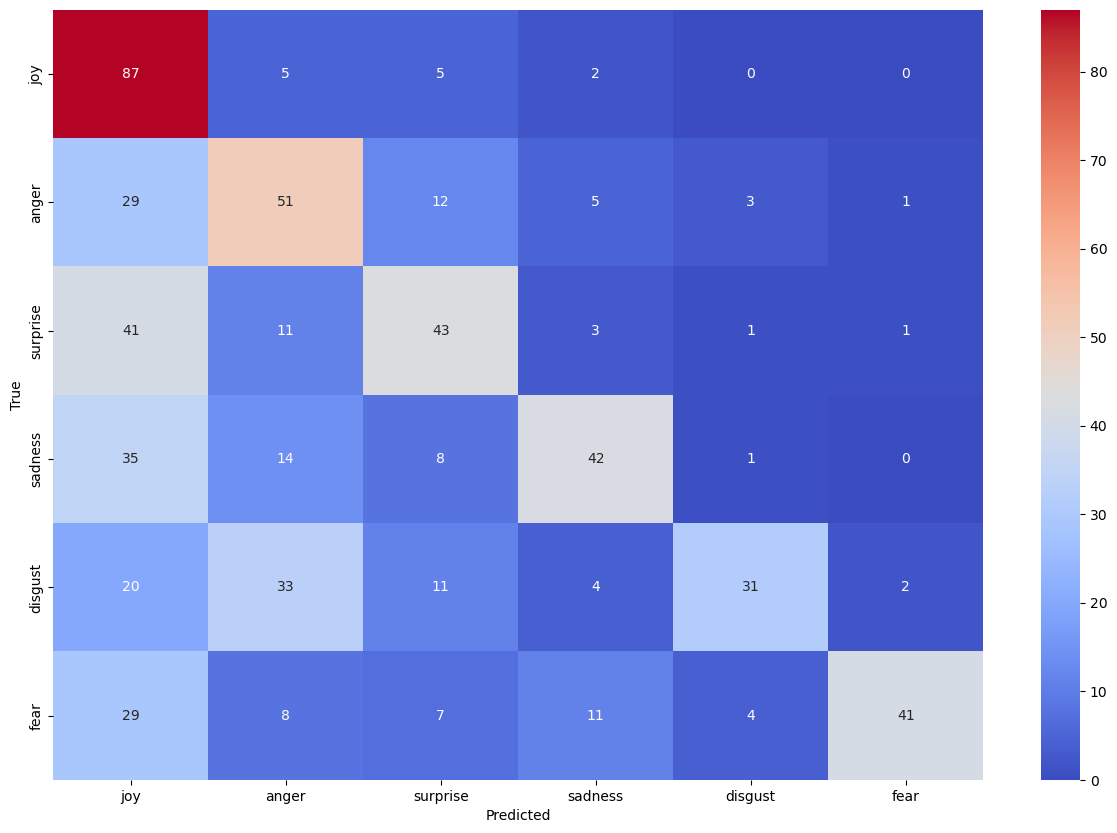

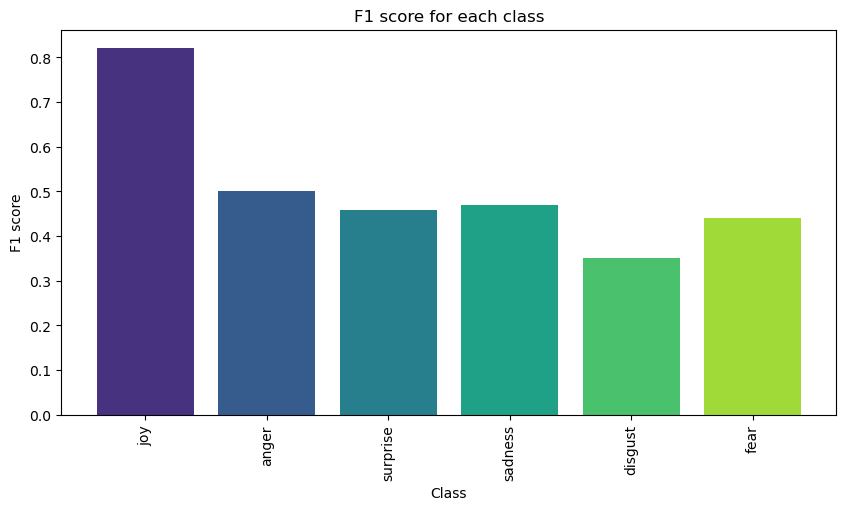

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.80                0.84                0.82                0.70                2104
anger                               0.60                0.43                0.50                0.33                 726
surprise                            0.59                0.38                0.46                0.30                 677
sadness                             0.63                0.37                0.47                0.31                 379
disgust                             0.54                0.26                0.35                0.21                 123
fear                                0.72                0.32                0.44                0.28                  98
Macro avg                           0.65                0.43                0.51                0.36                4107
Micro avg

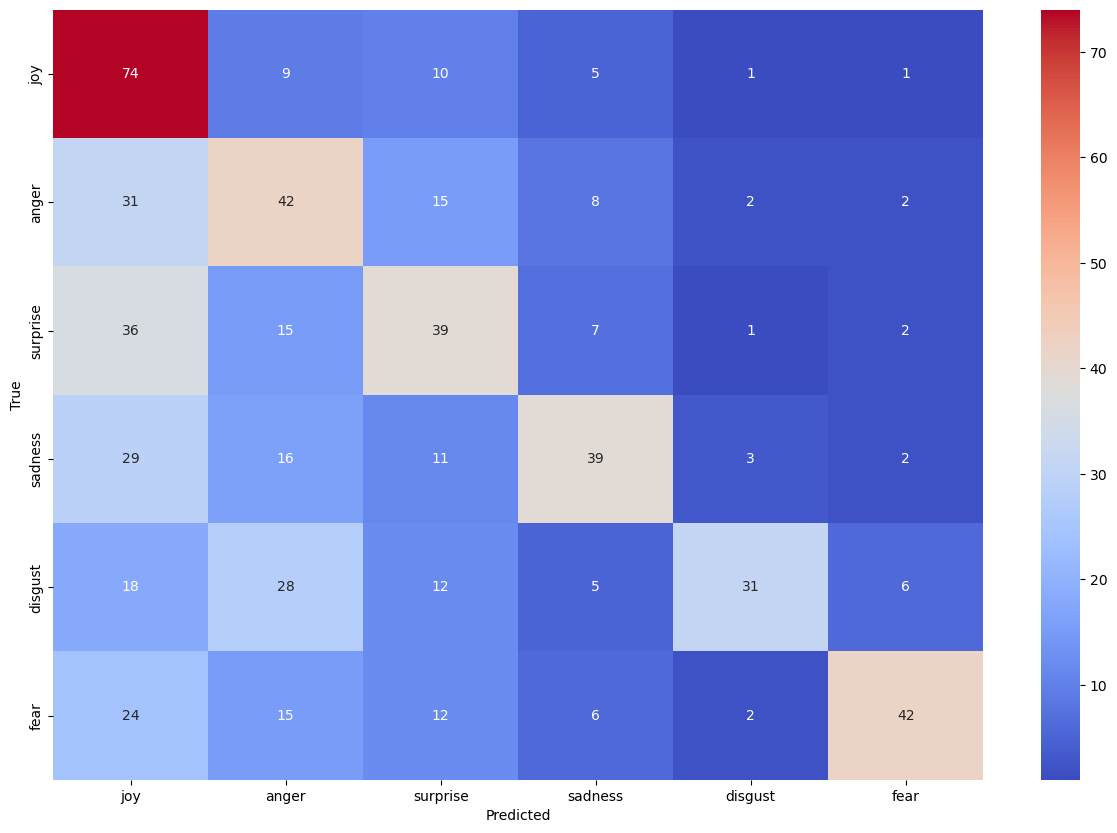

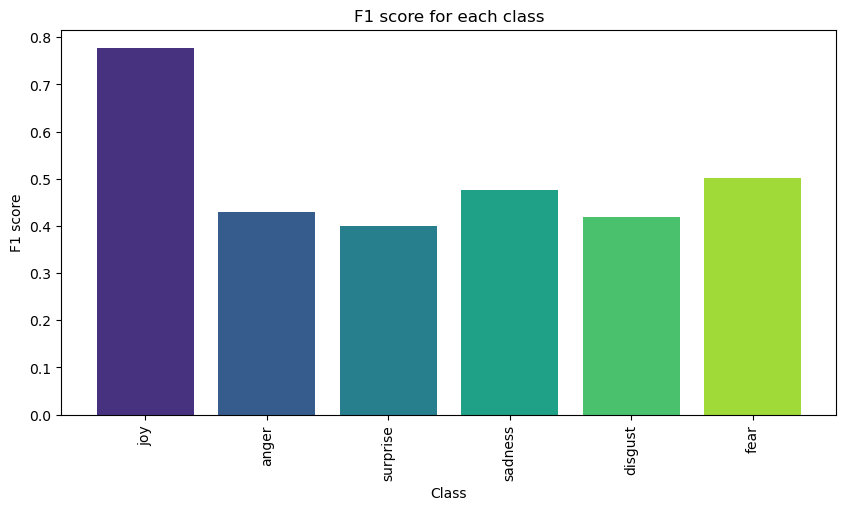

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.77                0.78                0.78                0.64                2104
anger                               0.45                0.41                0.43                0.27                 726
surprise                            0.42                0.38                0.40                0.25                 677
sadness                             0.49                0.47                0.48                0.31                 379
disgust                             0.52                0.35                0.42                0.27                 123
fear                                0.46                0.55                0.50                0.34                  98
Macro avg                           0.52                0.49                0.50                0.35                4107
Micro avg

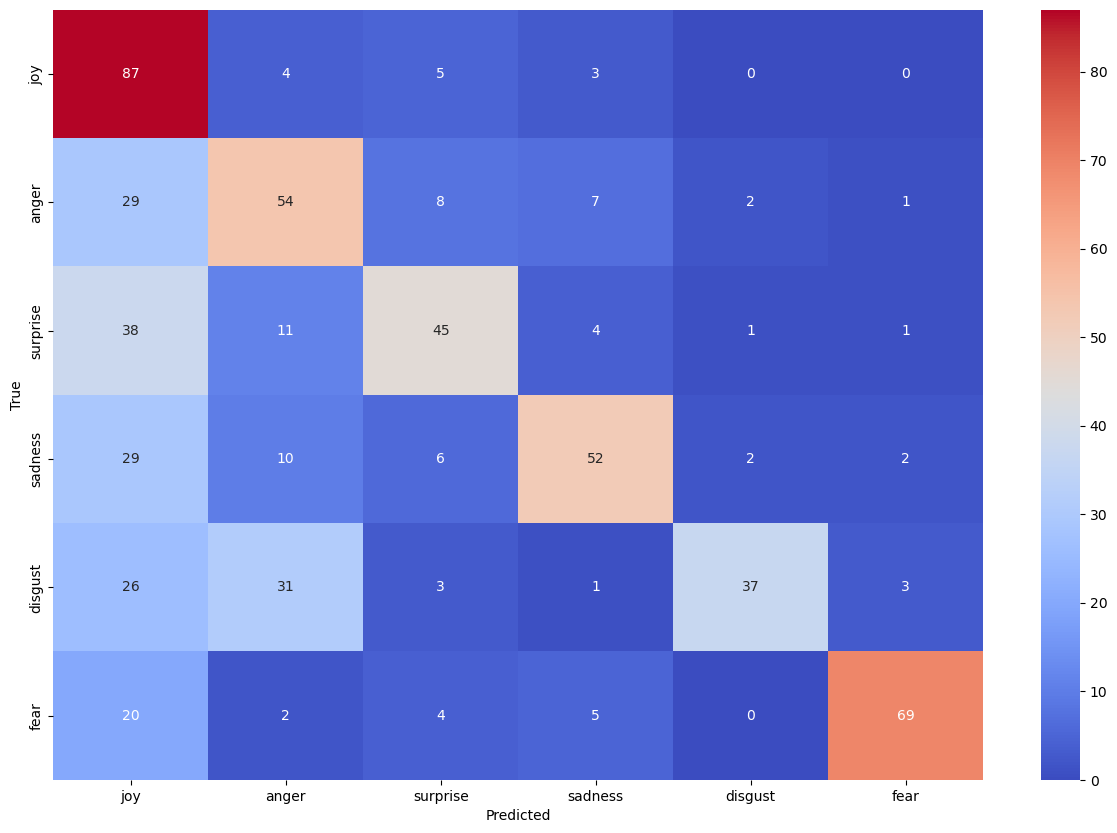

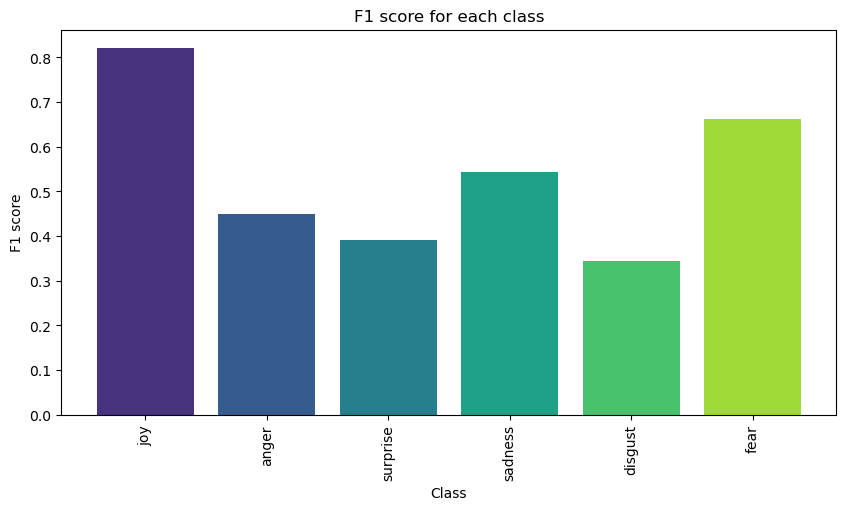

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.85                0.79                0.82                0.70                2104
anger                               0.65                0.34                0.45                0.29                 726
surprise                            0.63                0.29                0.39                0.24                 677
sadness                             0.67                0.46                0.54                0.37                 379
disgust                             0.63                0.24                0.34                0.21                 123
fear                                0.77                0.58                0.66                0.50                  98
Macro avg                           0.70                0.45                0.54                0.38                4107
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


----------------------------------------------------------------------
Model: Bert
Dataset: GoEmotionsGrouped


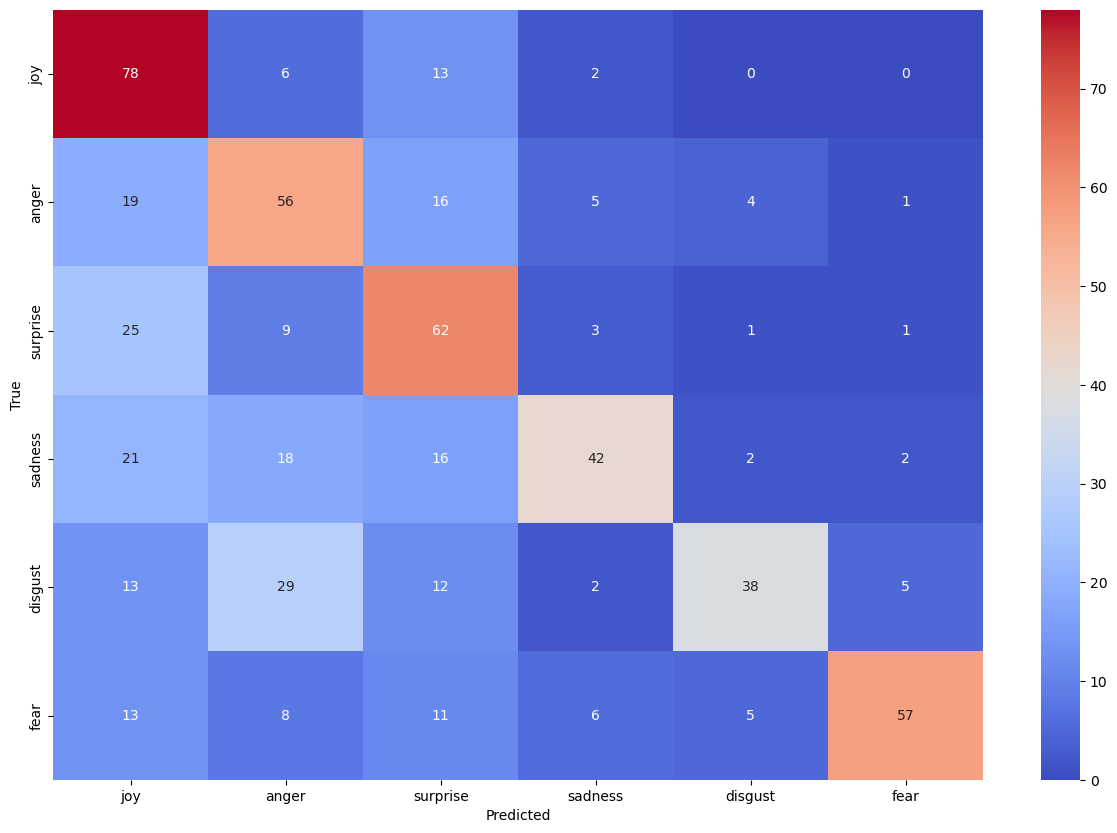

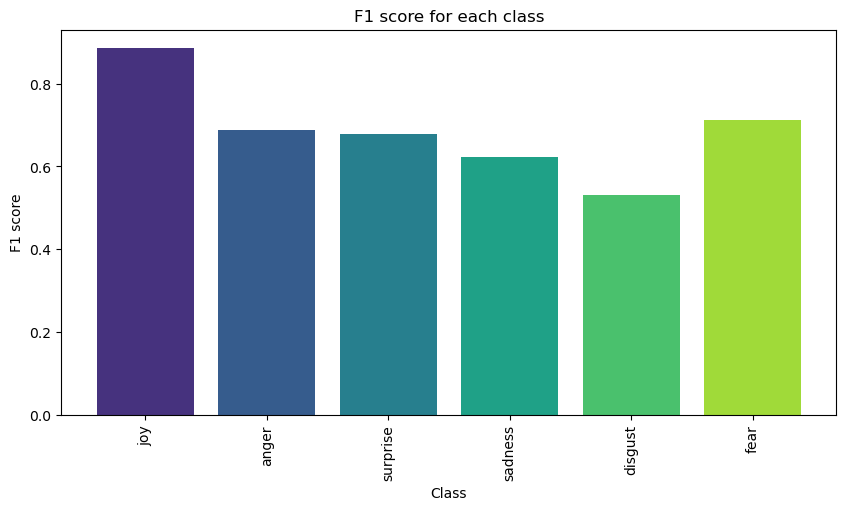

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.84                0.94                0.89                0.80                2104
anger                               0.64                0.74                0.69                0.52                 726
surprise                            0.56                0.86                0.68                0.51                 677
sadness                             0.68                0.58                0.62                0.45                 379
disgust                             0.57                0.50                0.53                0.36                 123
fear                                0.69                0.73                0.71                0.55                  98
Macro avg                           0.66                0.73                0.69                0.53                4107
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: Roberta
Dataset: GoEmotionsGrouped


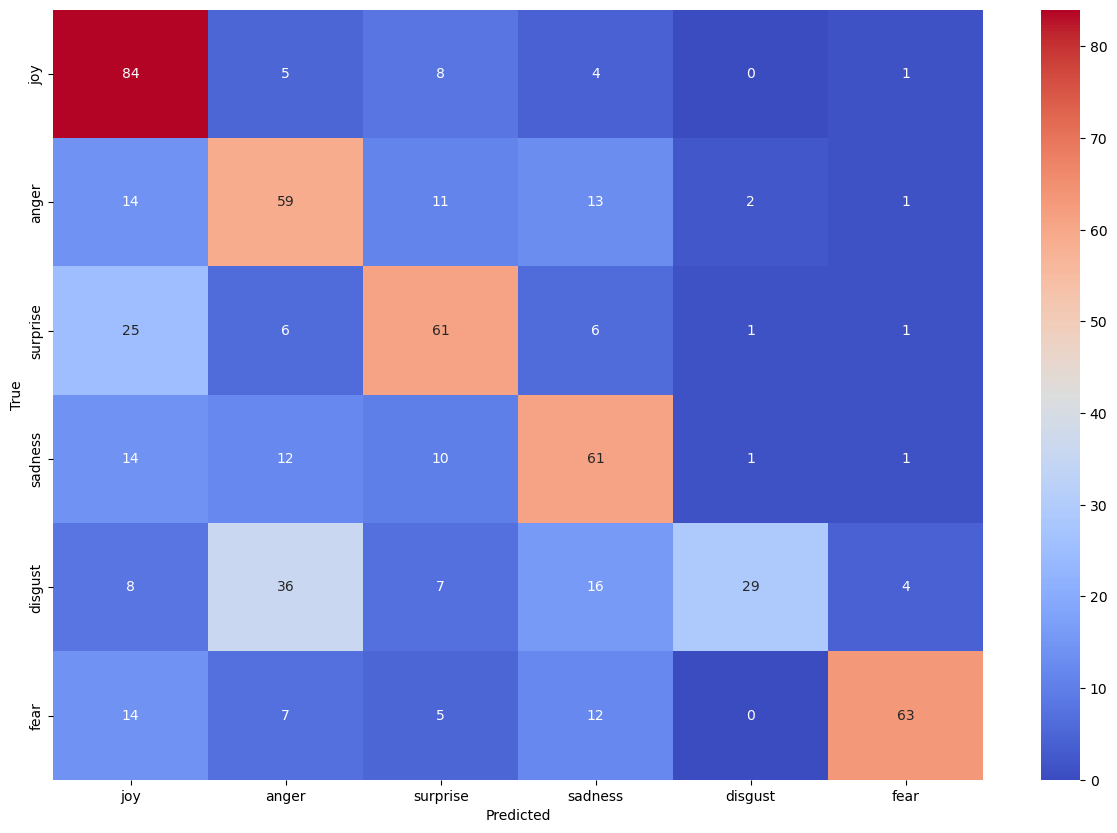

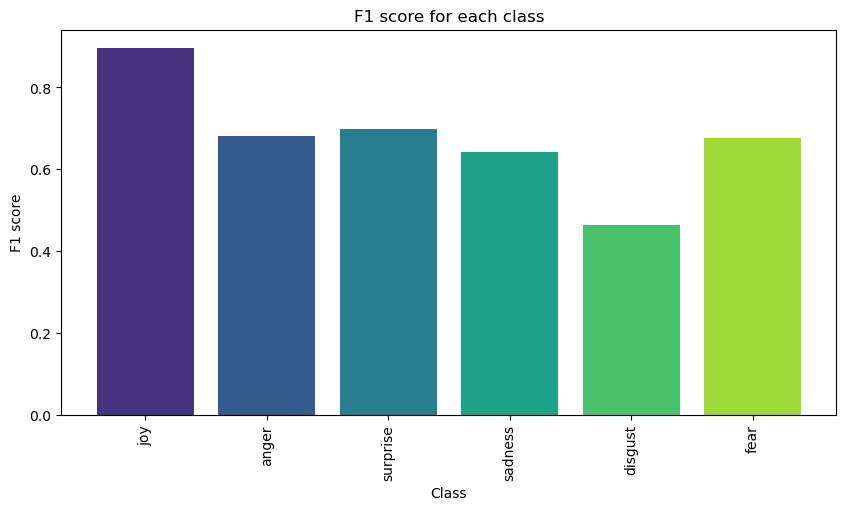

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.88                0.92                0.90                0.81                2104
anger                               0.70                0.67                0.68                0.52                 726
surprise                            0.67                0.73                0.70                0.54                 677
sadness                             0.57                0.73                0.64                0.47                 379
disgust                             0.68                0.35                0.46                0.30                 123
fear                                0.70                0.65                0.68                0.51                  98
Macro avg                           0.70                0.68                0.68                0.53                4107
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: SocBert
Dataset: GoEmotionsGrouped


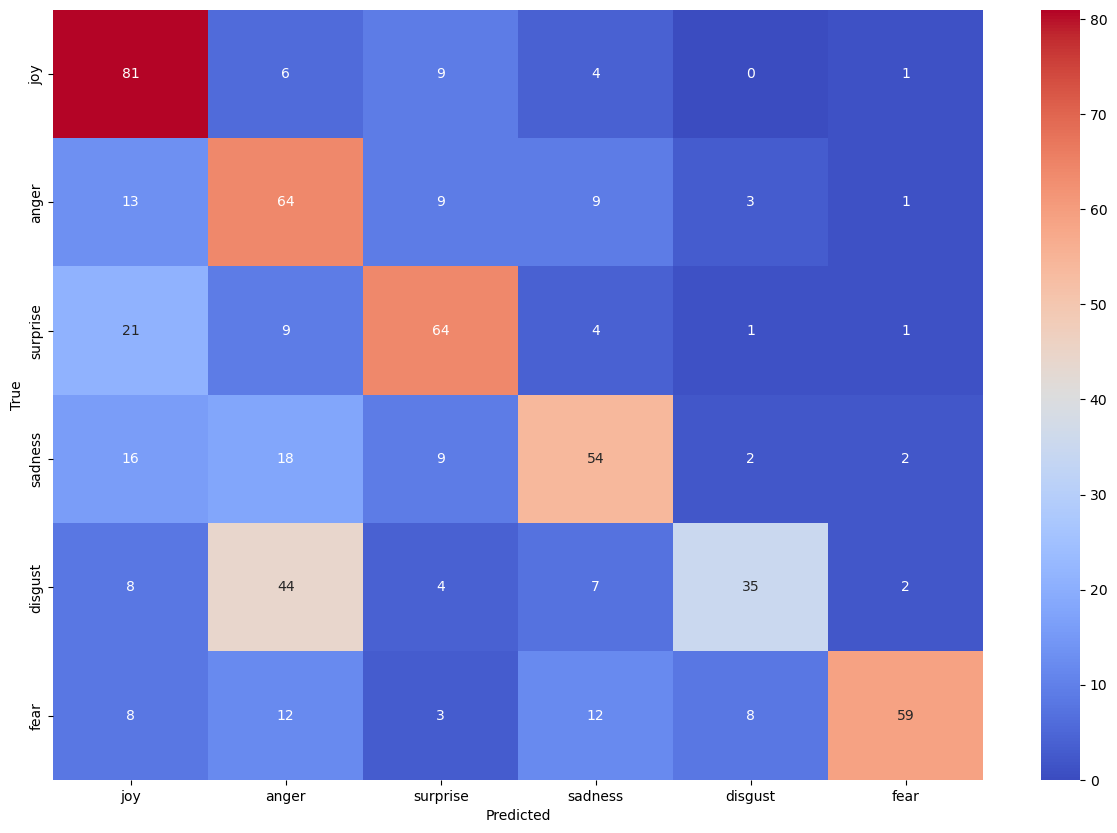

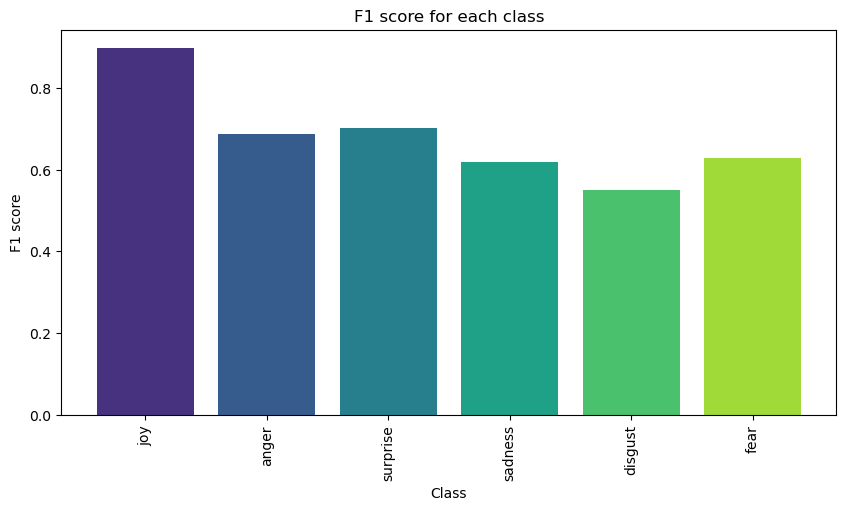

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.89                0.90                0.90                0.81                2104
anger                               0.64                0.74                0.69                0.52                 726
surprise                            0.67                0.74                0.70                0.54                 677
sadness                             0.59                0.65                0.62                0.45                 379
disgust                             0.63                0.49                0.55                0.38                 123
fear                                0.64                0.62                0.63                0.46                  98
Macro avg                           0.68                0.69                0.68                0.53                4107
Micro avg

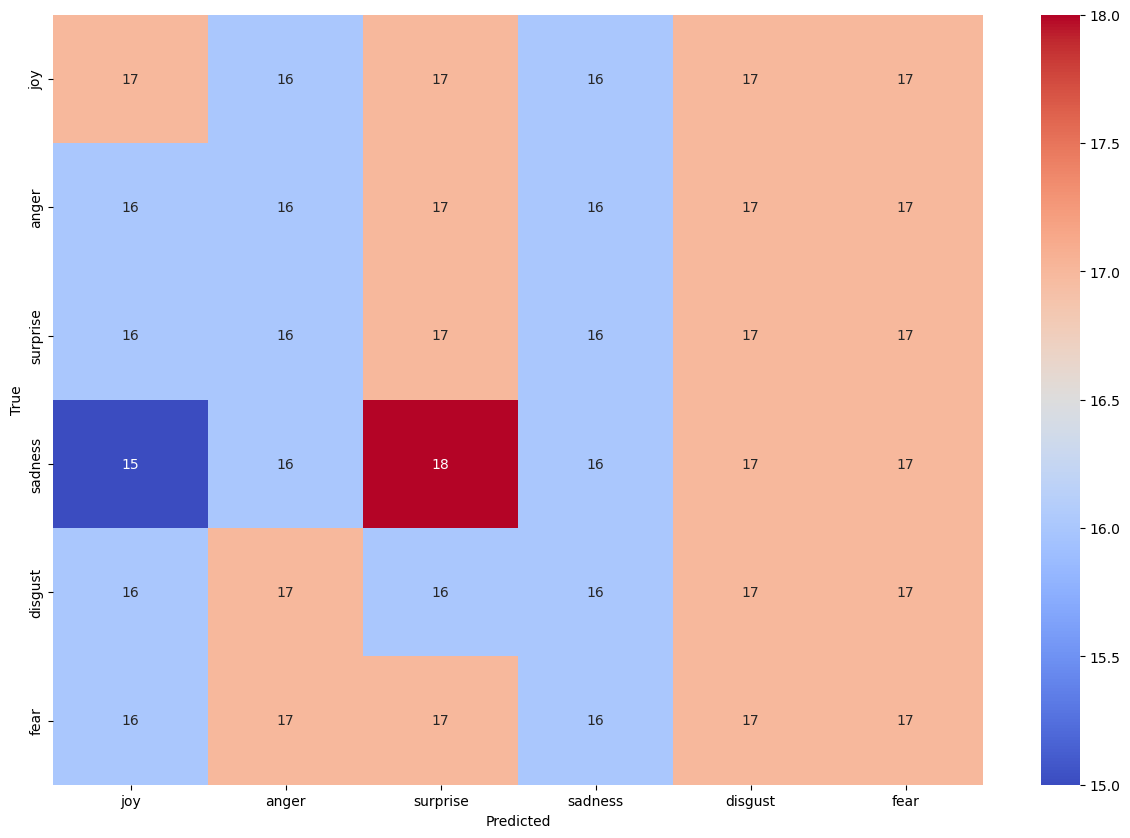

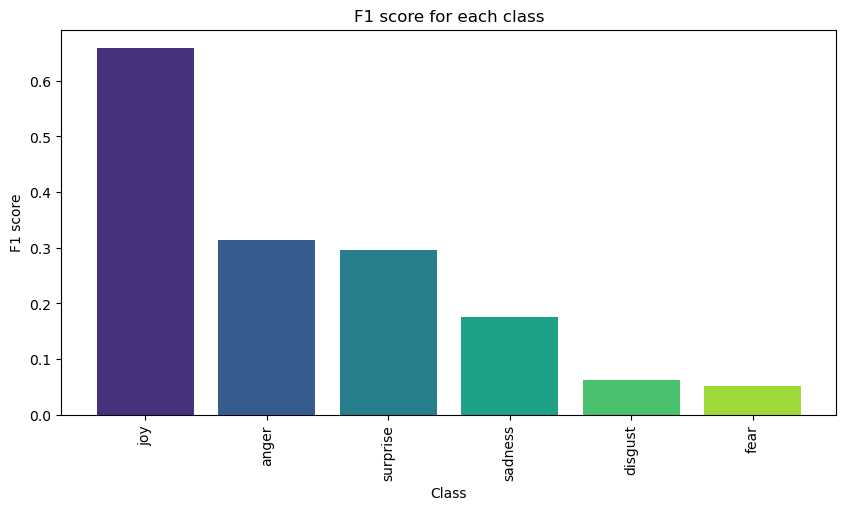

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.54                0.76                0.63                0.46                2104
anger                               0.20                0.84                0.32                0.19                 726
surprise                            0.18                0.84                0.30                0.18                 677
sadness                             0.09                0.73                0.16                0.09                 379
disgust                             0.03                0.76                0.06                0.03                 123
fear                                0.03                0.84                0.05                0.03                  98
Macro avg                           0.18                0.79                0.25                0.16                4107
Micro avg

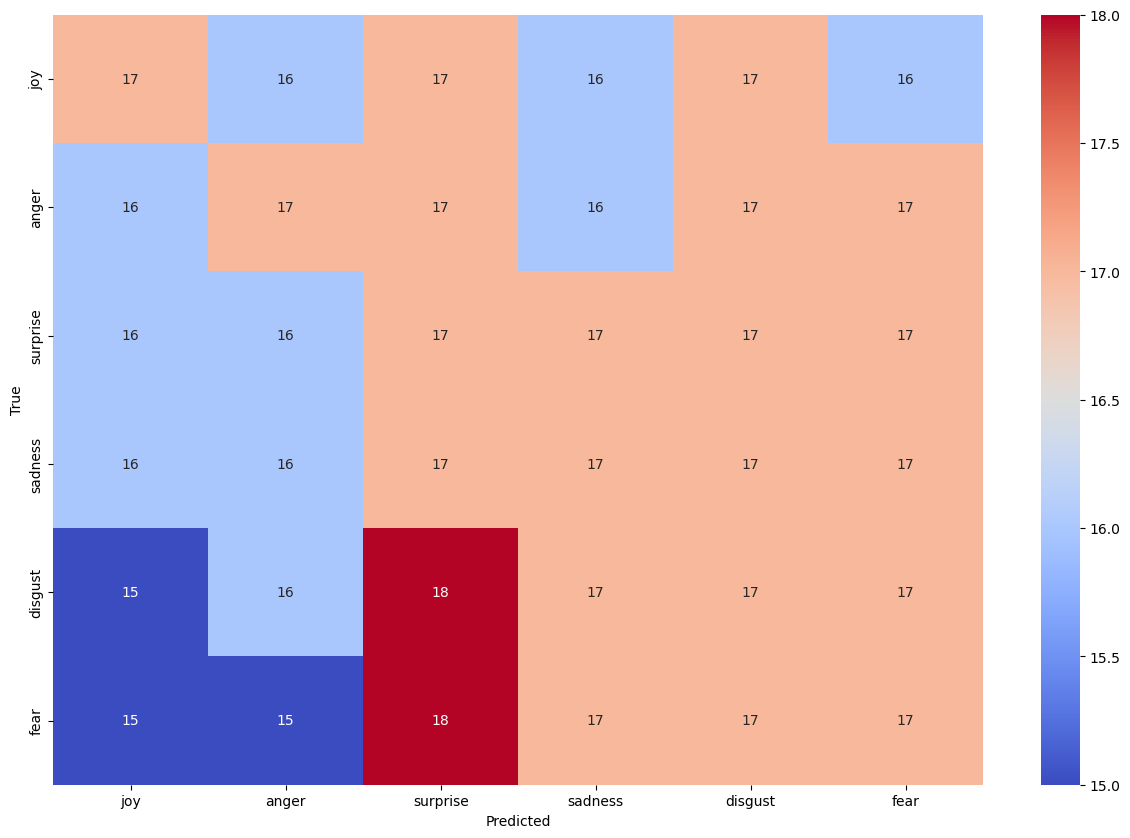

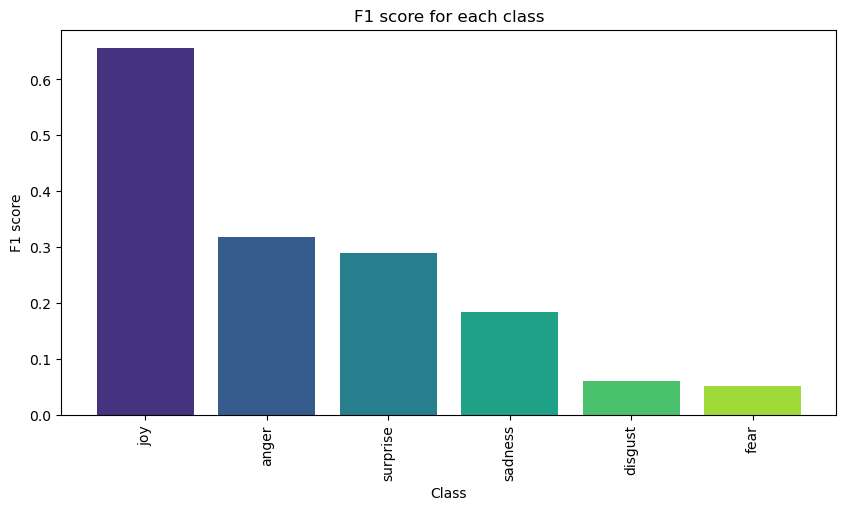

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.55                0.77                0.64                0.47                2104
anger                               0.20                0.84                0.32                0.19                 726
surprise                            0.18                0.81                0.29                0.17                 677
sadness                             0.10                0.79                0.18                0.10                 379
disgust                             0.03                0.80                0.06                0.03                 123
fear                                0.03                0.88                0.05                0.03                  98
Macro avg                           0.18                0.82                0.26                0.16                4107
Micro avg

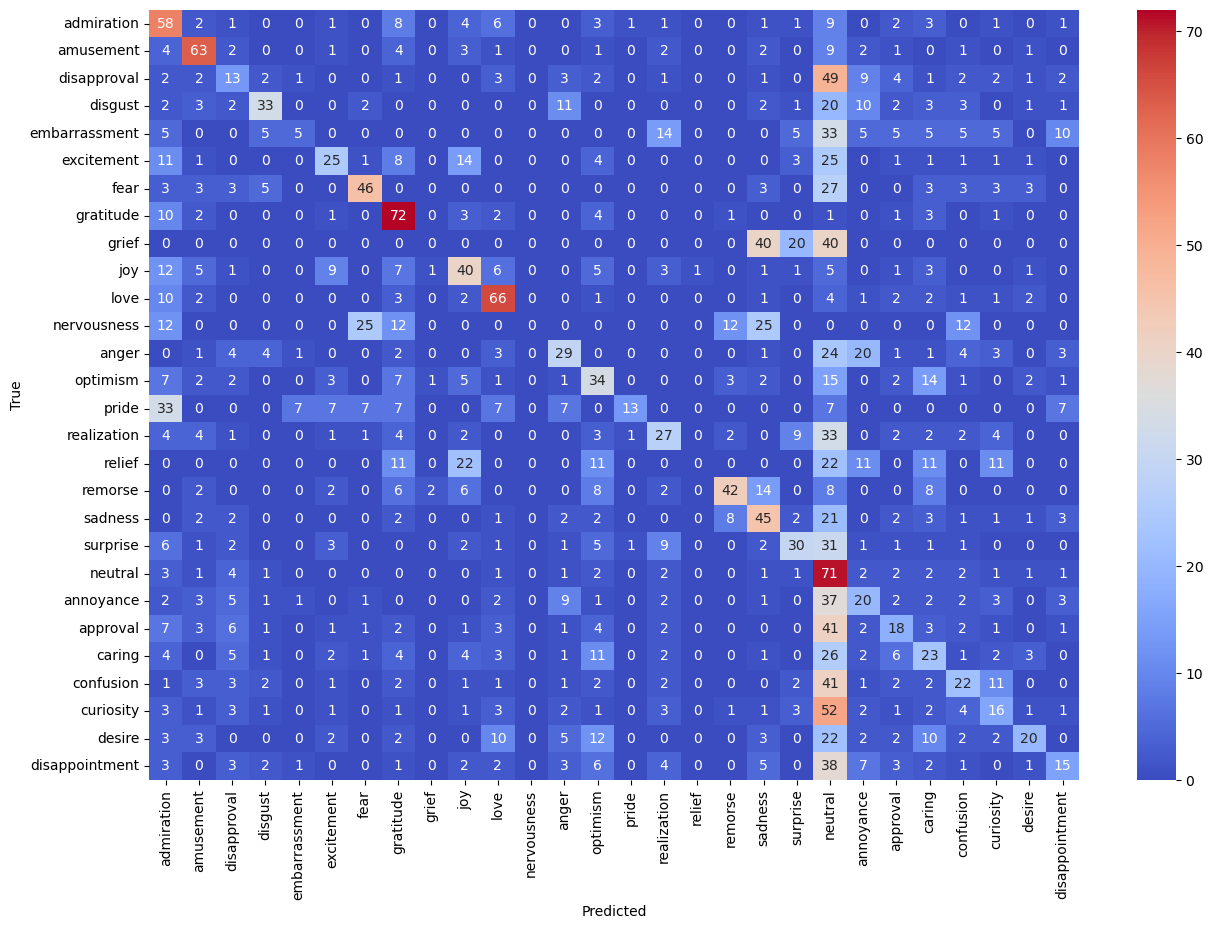

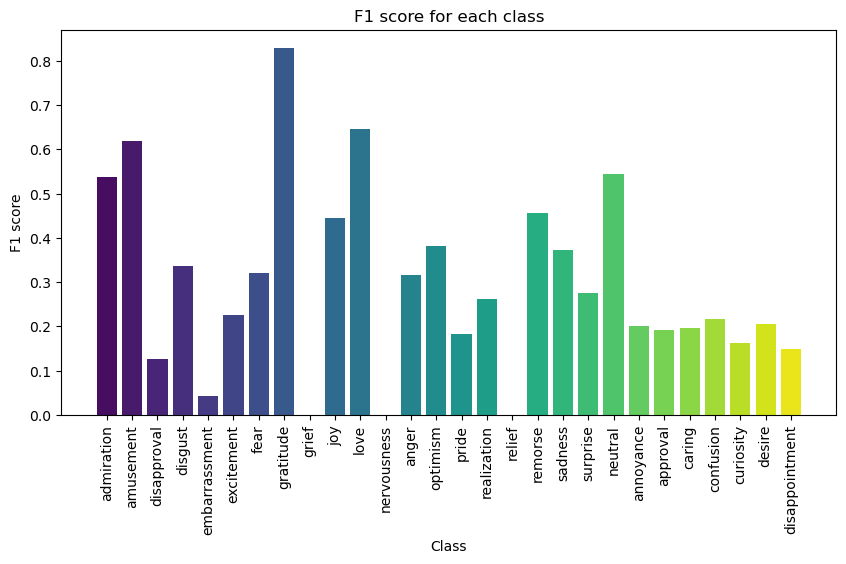

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.65                0.46                0.54                0.37                 504
amusement                           0.78                0.51                0.62                0.45                 264
disapproval                         0.20                0.09                0.13                0.07                 267
disgust                             0.59                0.24                0.34                0.20                 123
embarrassment                       0.10                0.03                0.04                0.02                  37
excitement                          0.32                0.17                0.23                0.13                 103
fear                                0.61                0.22                0.32                0.19                  78
gratitude

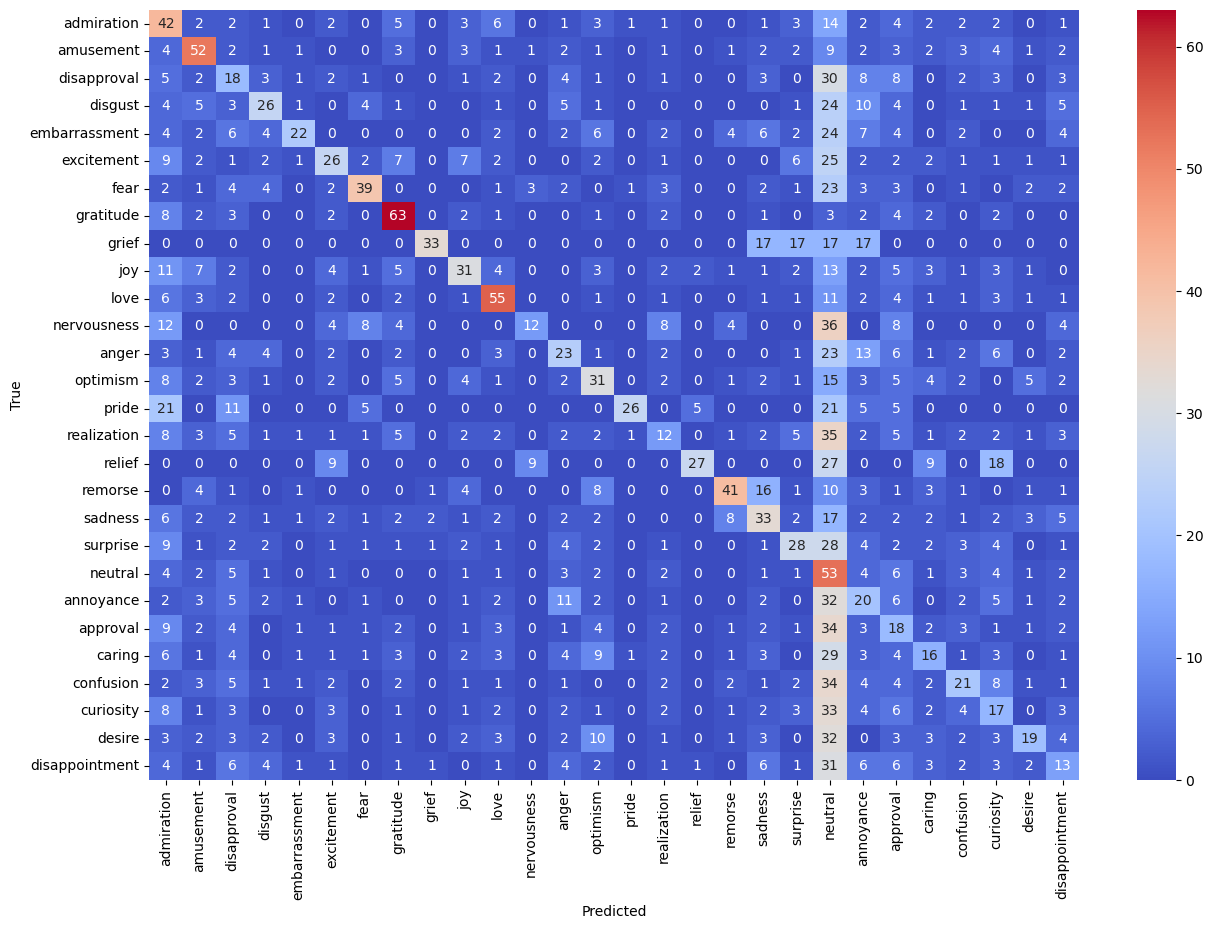

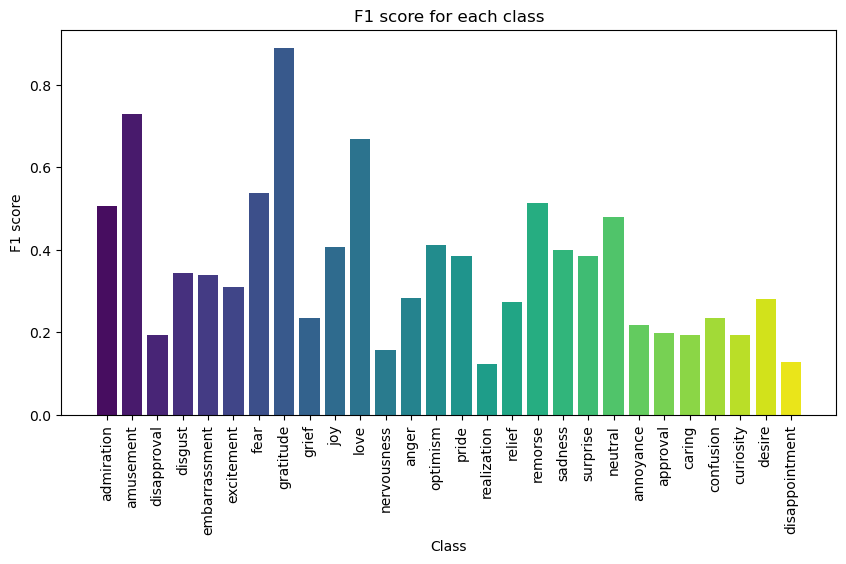

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.52                0.50                0.51                0.34                 504
amusement                           0.73                0.73                0.73                0.57                 264
disapproval                         0.21                0.18                0.19                0.11                 267
disgust                             0.41                0.29                0.34                0.21                 123
embarrassment                       0.35                0.32                0.34                0.20                  37
excitement                          0.31                0.31                0.31                0.18                 103
fear                                0.60                0.49                0.54                0.37                  78
gratitude

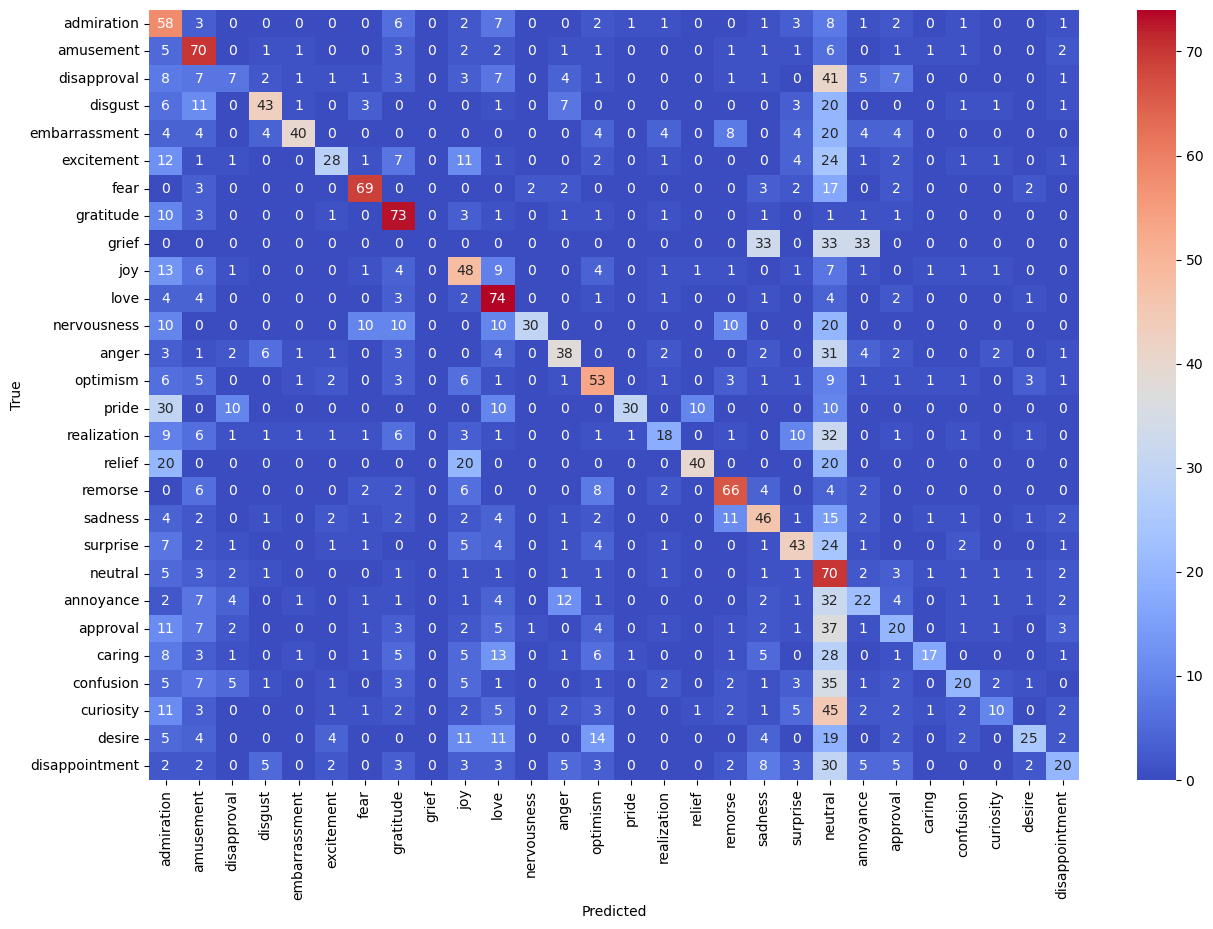

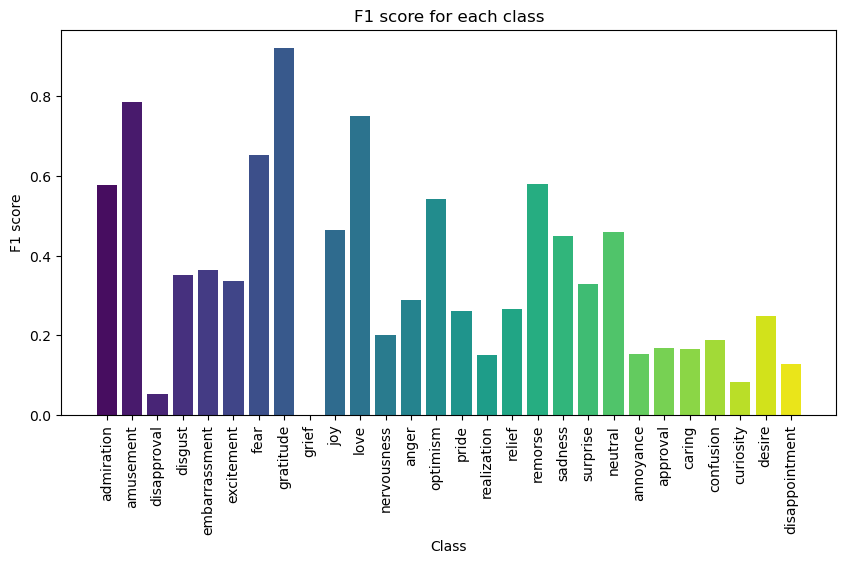

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.64                0.52                0.58                0.40                 504
amusement                           0.76                0.81                0.79                0.65                 264
disapproval                         0.18                0.03                0.05                0.03                 267
disgust                             0.62                0.24                0.35                0.21                 123
embarrassment                       0.56                0.27                0.36                0.22                  37
excitement                          0.60                0.23                0.34                0.20                 103
fear                                0.77                0.56                0.65                0.48                  78
gratitude

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


----------------------------------------------------------------------
Model: Bert
Dataset: GoEmotions


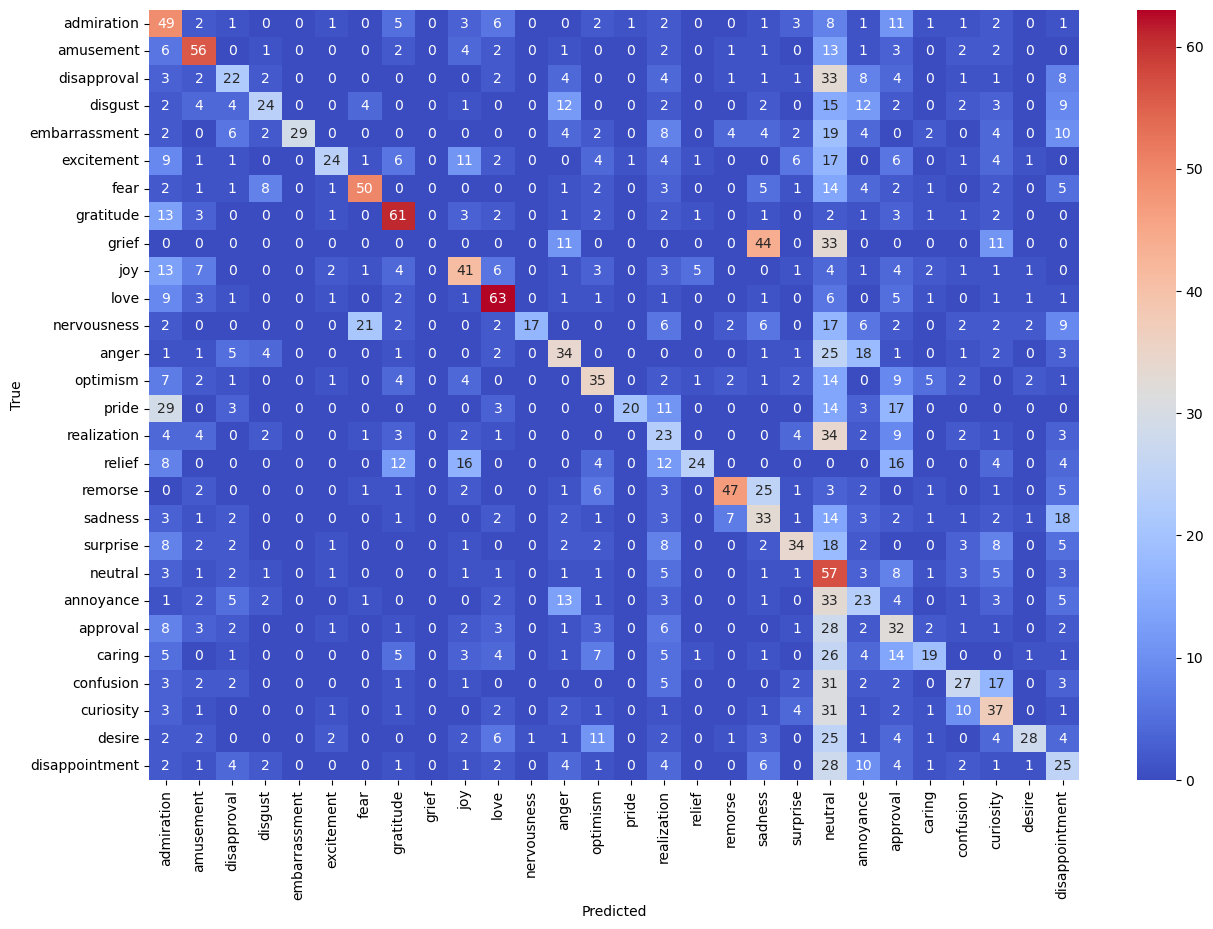

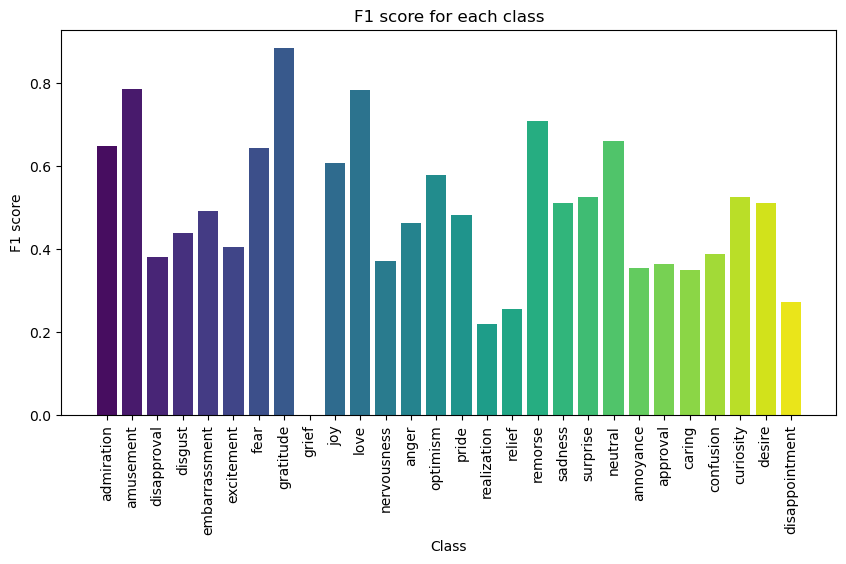

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.57                0.75                0.65                0.48                 504
amusement                           0.72                0.87                0.79                0.65                 264
disapproval                         0.43                0.34                0.38                0.23                 267
disgust                             0.49                0.40                0.44                0.28                 123
embarrassment                       0.62                0.41                0.49                0.33                  37
excitement                          0.45                0.37                0.41                0.26                 103
fear                                0.59                0.71                0.64                0.47                  78
gratitude

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: Roberta
Dataset: GoEmotions


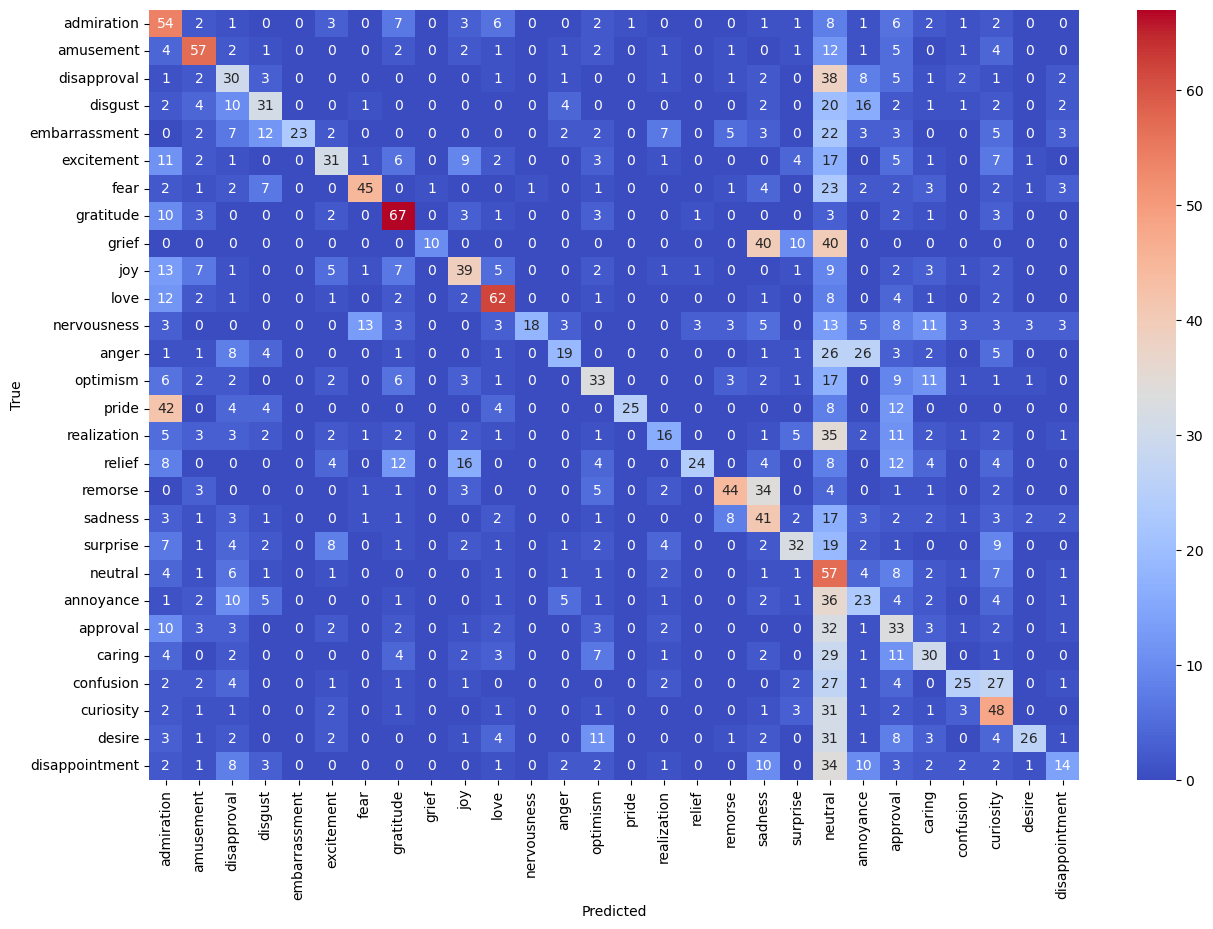

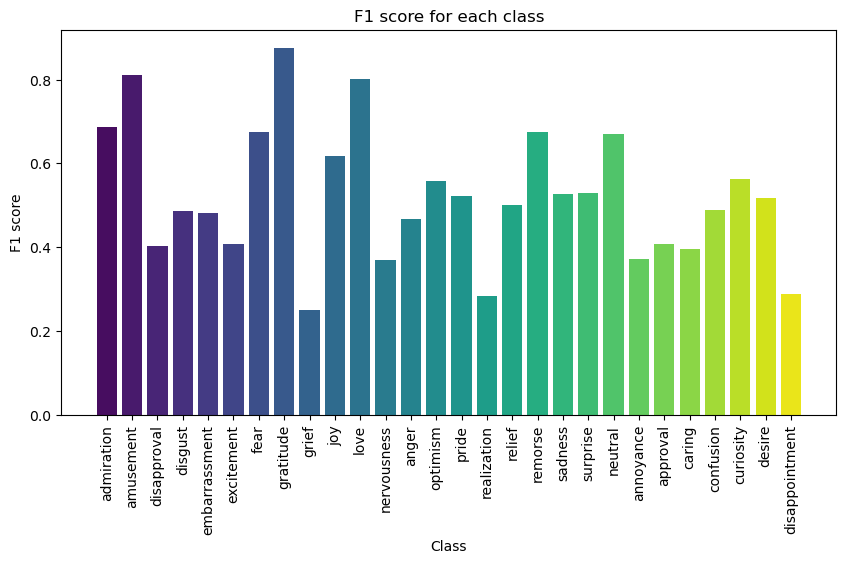

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.59                0.82                0.69                0.52                 504
amusement                           0.73                0.91                0.81                0.68                 264
disapproval                         0.32                0.55                0.40                0.25                 267
disgust                             0.44                0.55                0.49                0.32                 123
embarrassment                       0.67                0.38                0.48                0.32                  37
excitement                          0.33                0.52                0.41                0.26                 103
fear                                0.73                0.63                0.68                0.51                  78
gratitude

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: SocBert
Dataset: GoEmotions


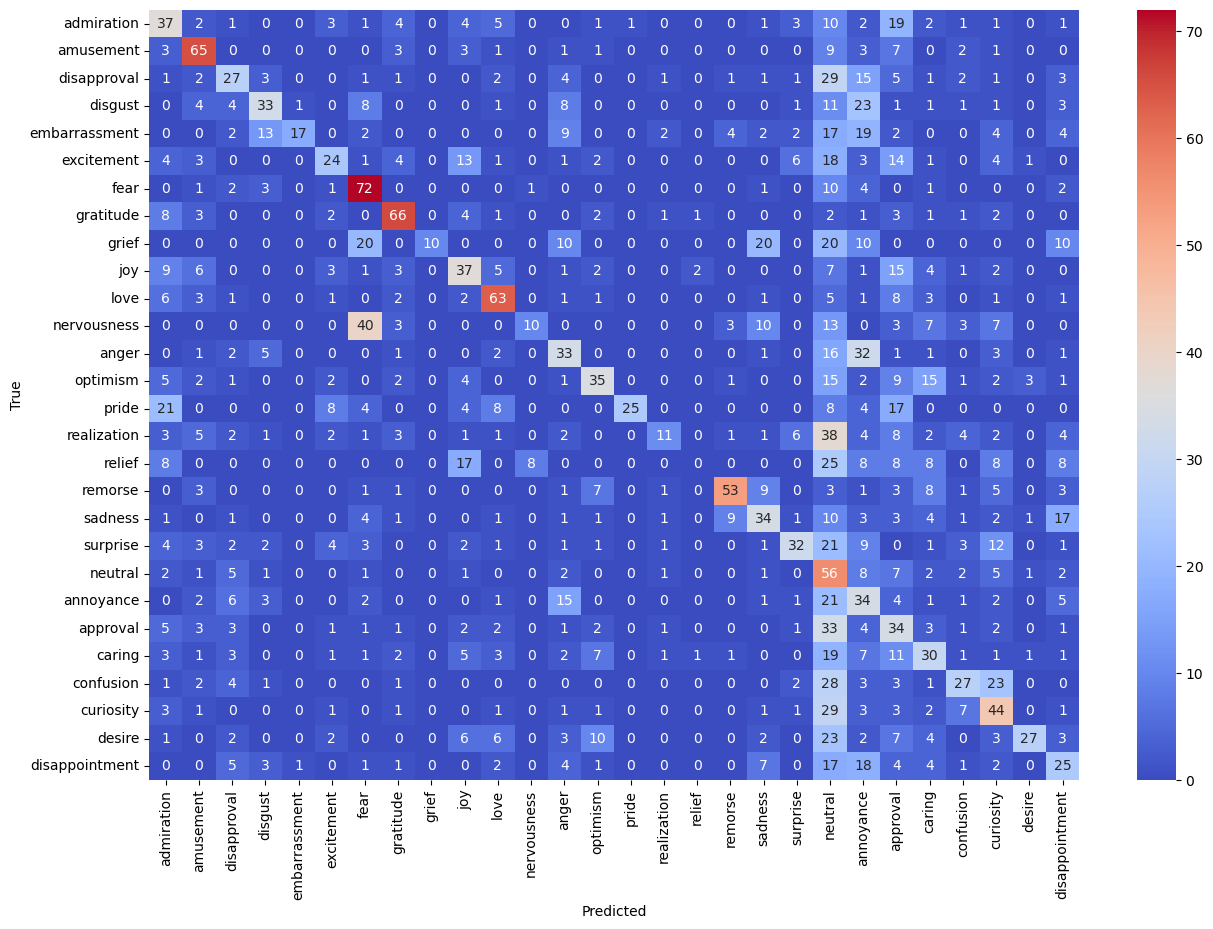

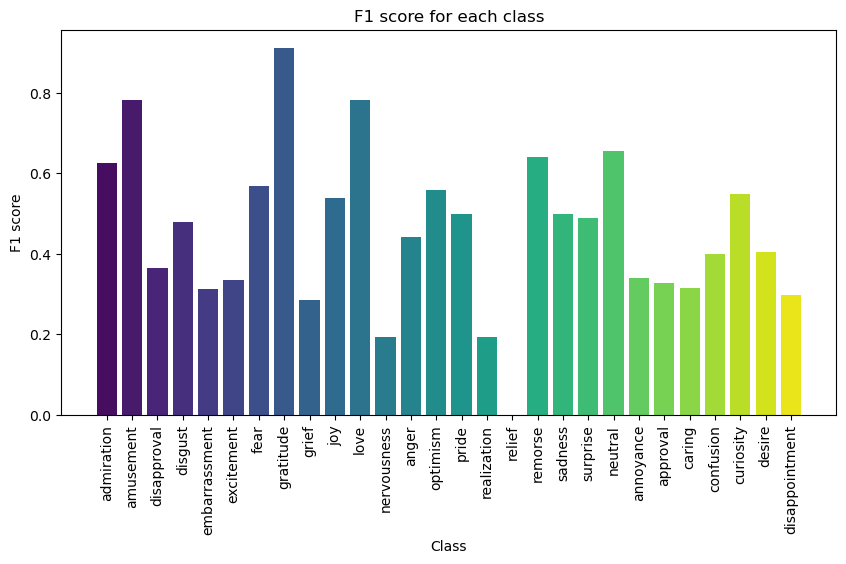

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.70                0.57                0.63                0.46                 504
amusement                           0.74                0.83                0.78                0.64                 264
disapproval                         0.35                0.38                0.36                0.22                 267
disgust                             0.52                0.45                0.48                0.32                 123
embarrassment                       0.57                0.22                0.31                0.19                  37
excitement                          0.35                0.32                0.34                0.20                 103
fear                                0.44                0.82                0.57                0.40                  78
gratitude

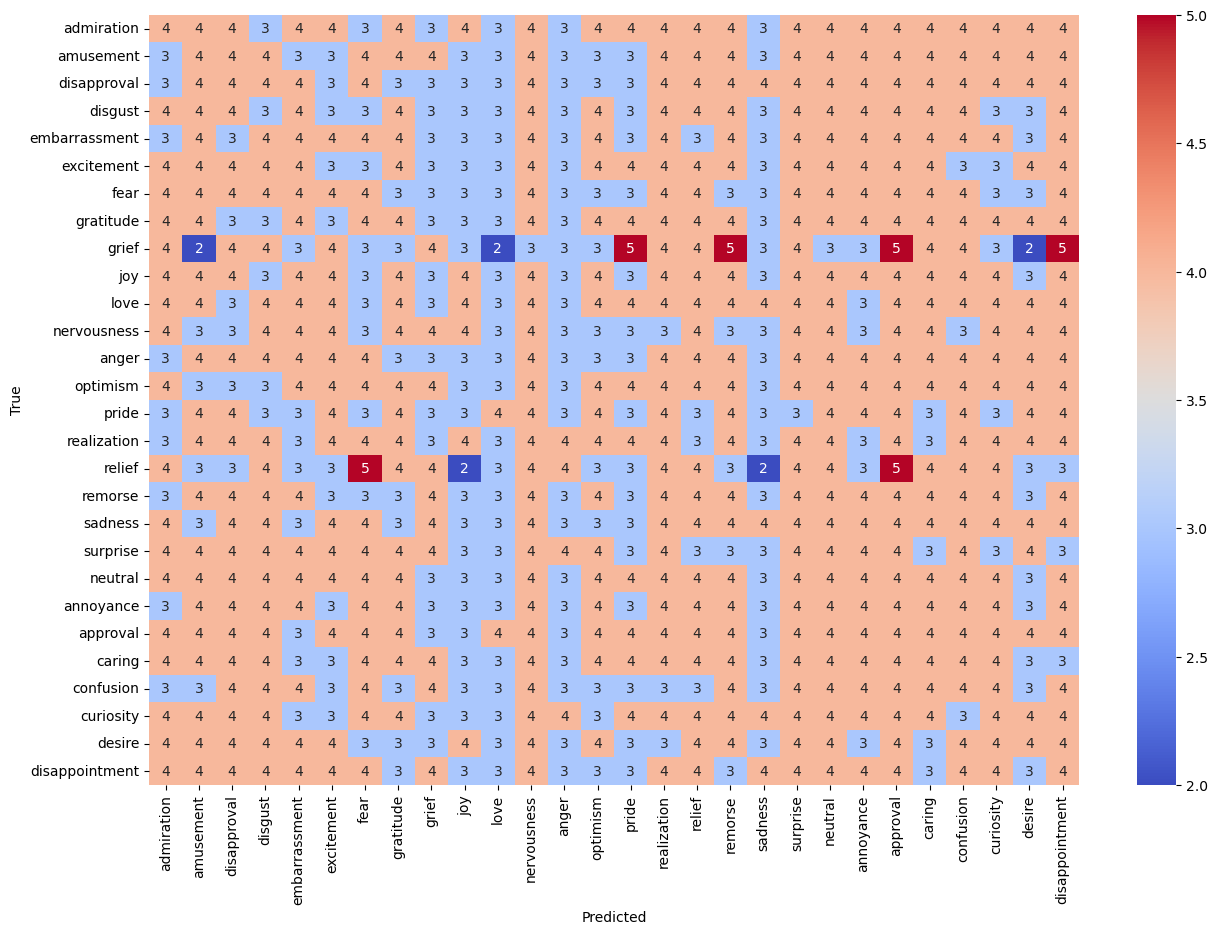

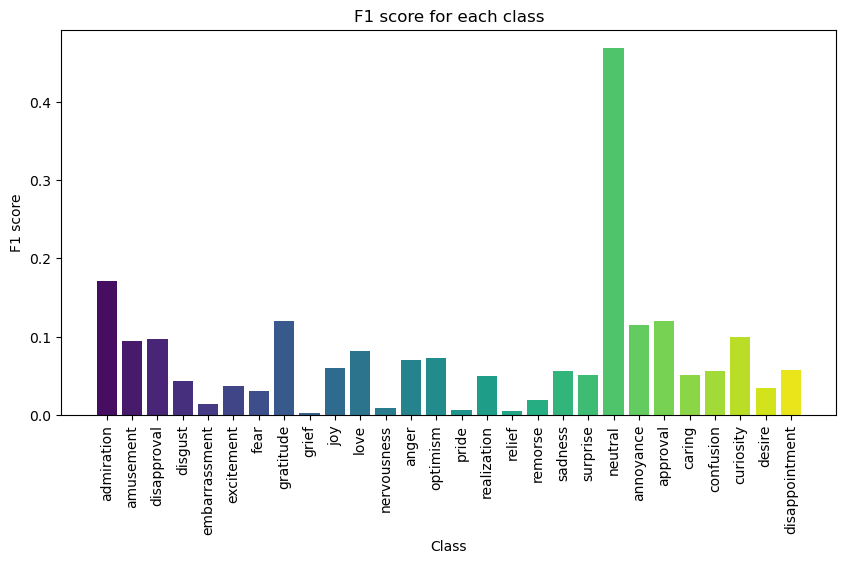

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.10                0.83                0.17                0.09                 504
amusement                           0.05                0.84                0.09                0.05                 264
disapproval                         0.05                0.81                0.10                0.05                 267
disgust                             0.02                0.87                0.05                0.02                 123
embarrassment                       0.01                0.86                0.01                0.01                  37
excitement                          0.02                0.81                0.04                0.02                 103
fear                                0.01                0.81                0.03                0.01                  78
gratitude

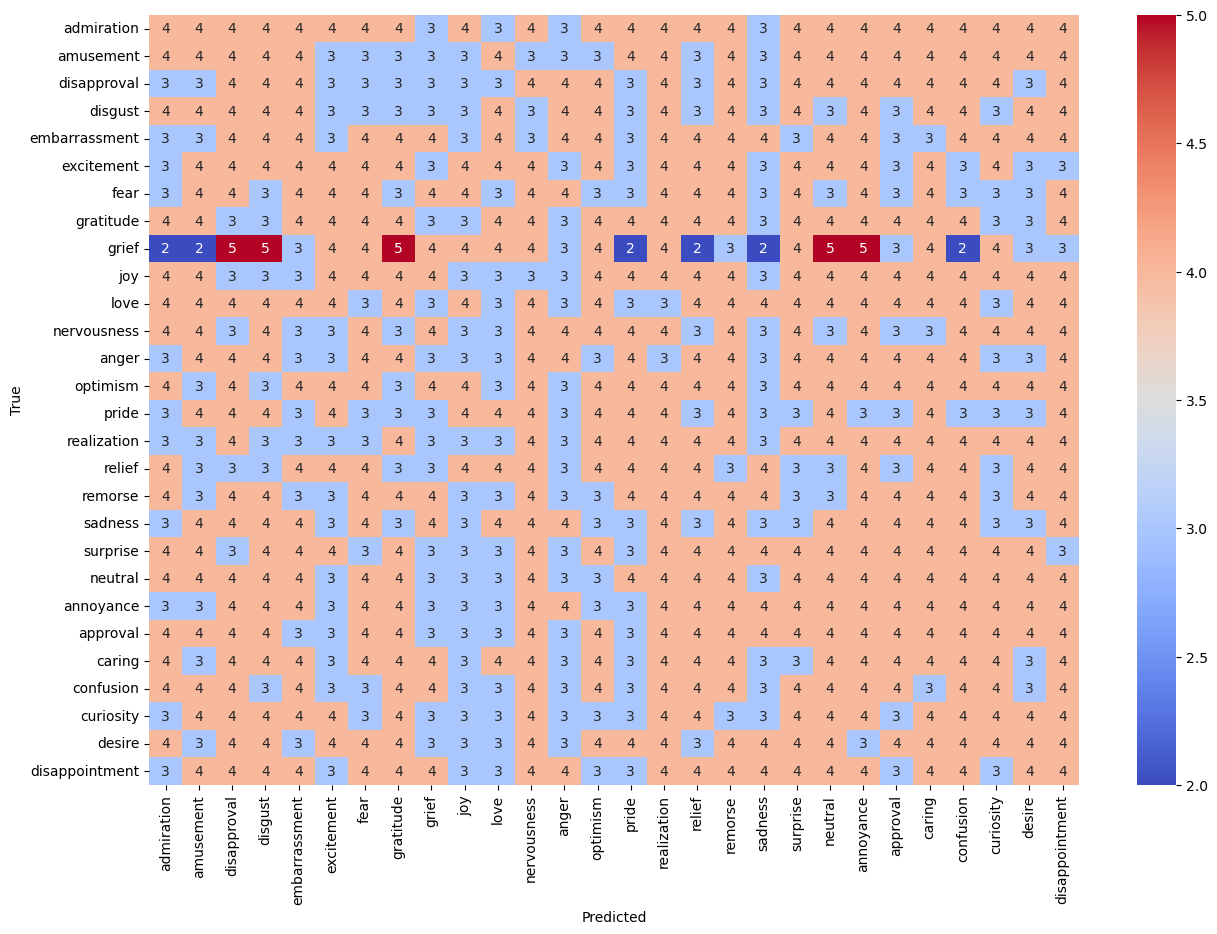

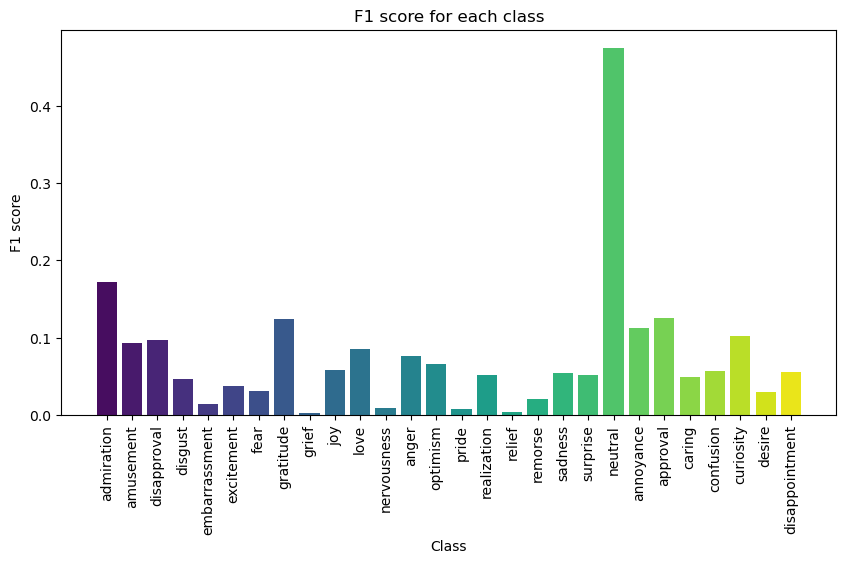

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.10                0.84                0.17                0.09                 504
amusement                           0.05                0.83                0.09                0.05                 264
disapproval                         0.05                0.81                0.10                0.05                 267
disgust                             0.02                0.89                0.05                0.02                 123
embarrassment                       0.01                0.78                0.01                0.01                  37
excitement                          0.02                0.83                0.04                0.02                 103
fear                                0.01                0.74                0.02                0.01                  78
gratitude

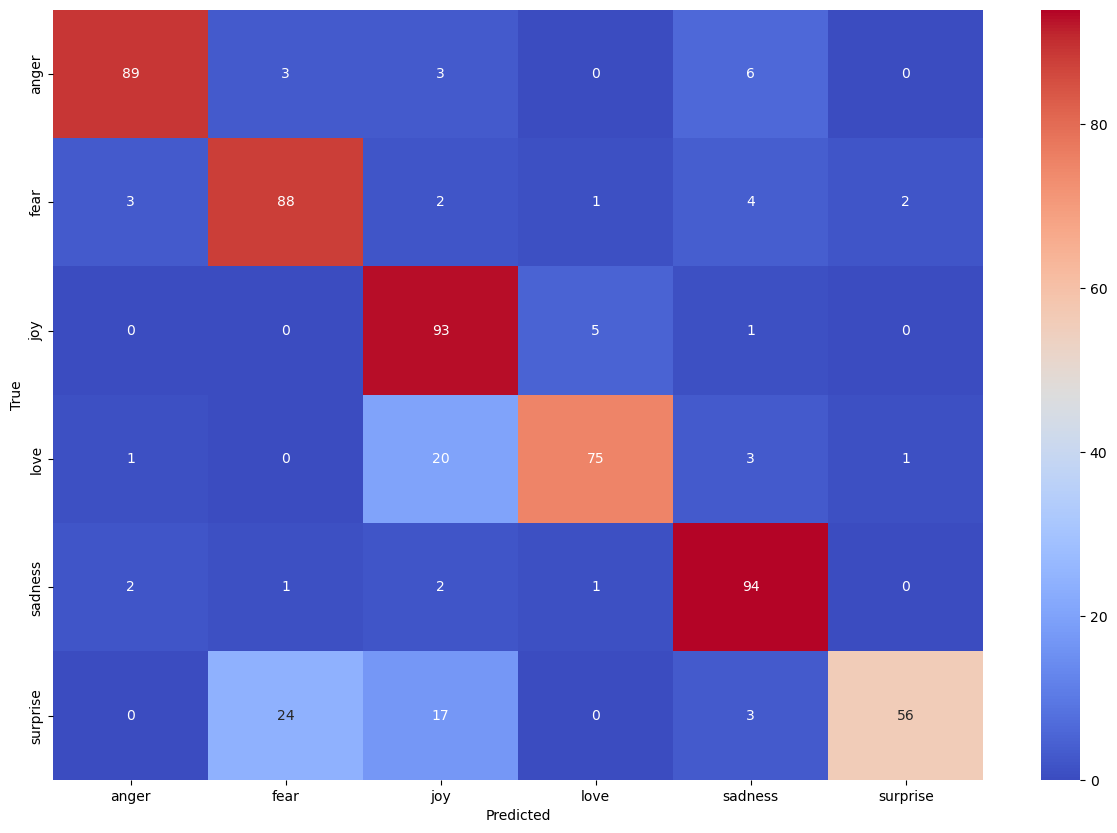

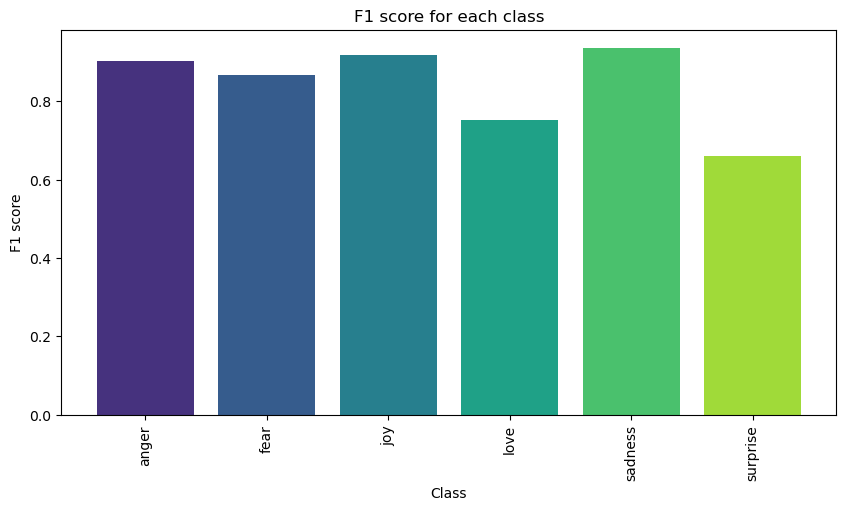

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.92                0.89                0.90                0.82                 275
fear                                0.85                0.88                0.87                0.76                 224
joy                                 0.91                0.93                0.92                0.85                 695
love                                0.75                0.75                0.75                0.60                 159
sadness                             0.93                0.94                0.94                0.88                 581
surprise                            0.80                0.56                0.66                0.49                  66
Macro avg                           0.86                0.82                0.84                0.74                2000
Micro avg

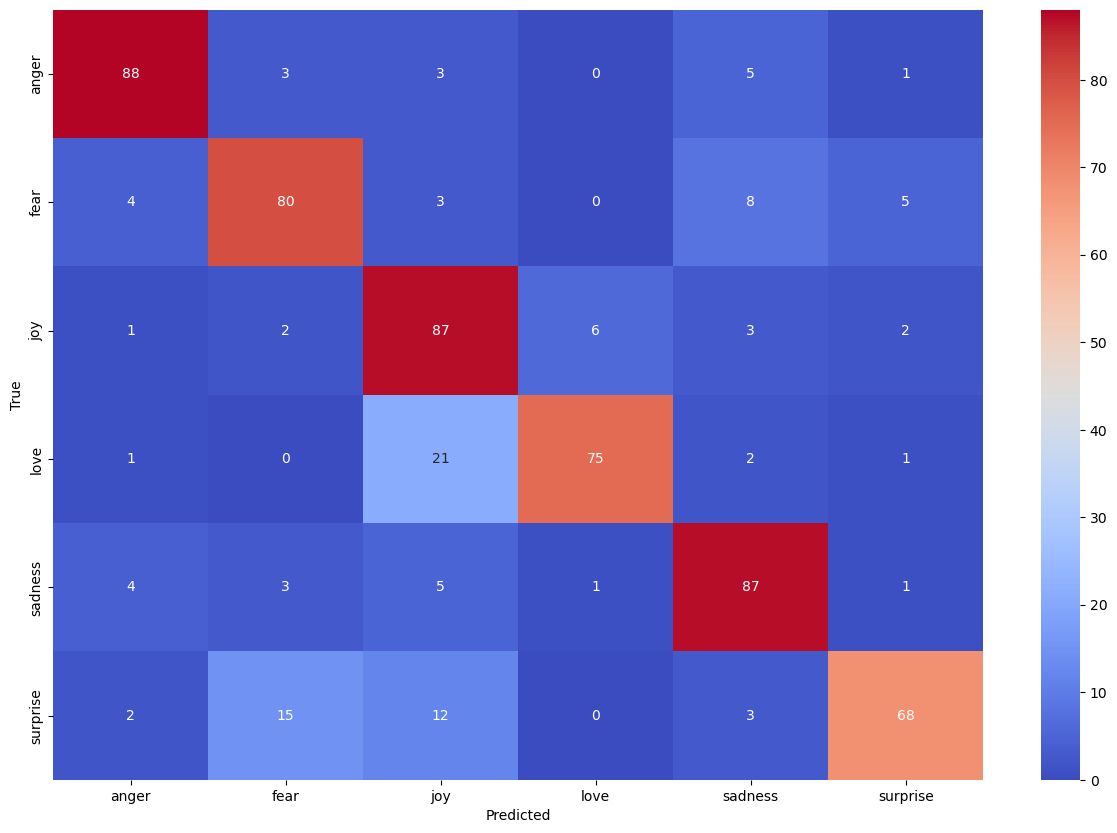

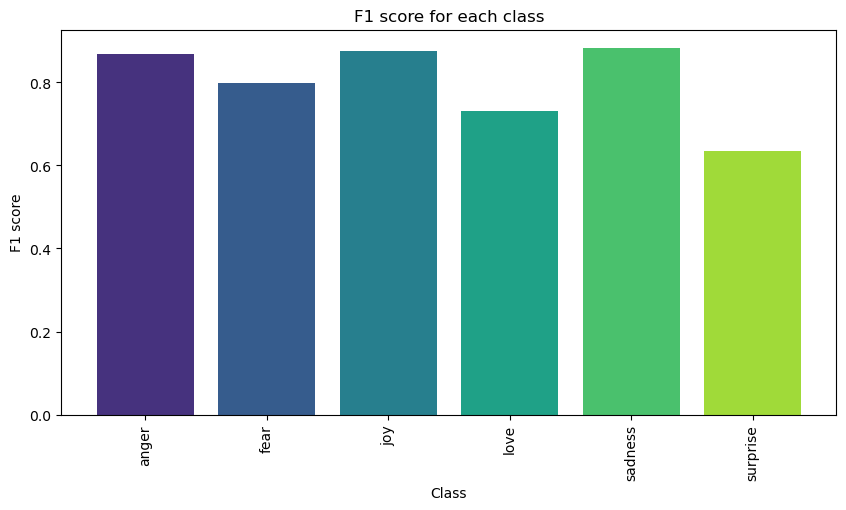

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.86                0.88                0.87                0.77                 275
fear                                0.80                0.80                0.80                0.67                 224
joy                                 0.88                0.87                0.87                0.78                 695
love                                0.71                0.75                0.73                0.57                 159
sadness                             0.90                0.87                0.88                0.79                 581
surprise                            0.59                0.68                0.63                0.46                  66
Macro avg                           0.79                0.81                0.80                0.67                2000
Micro avg

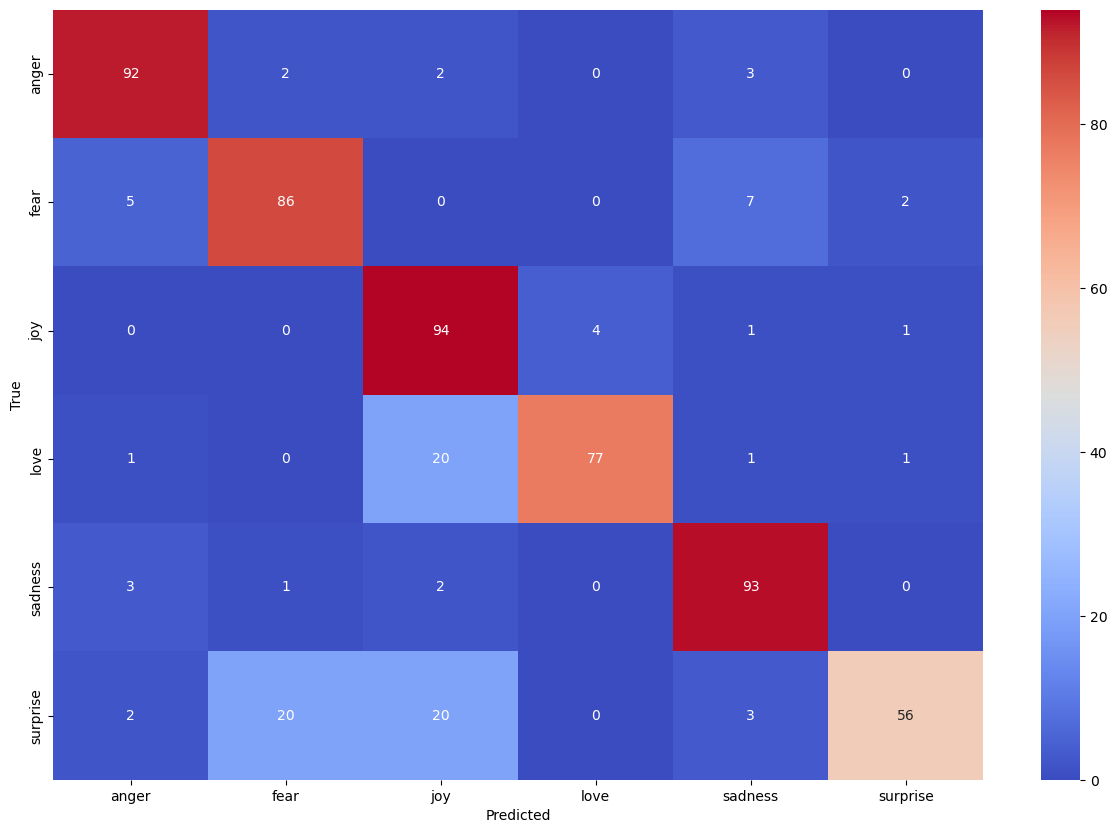

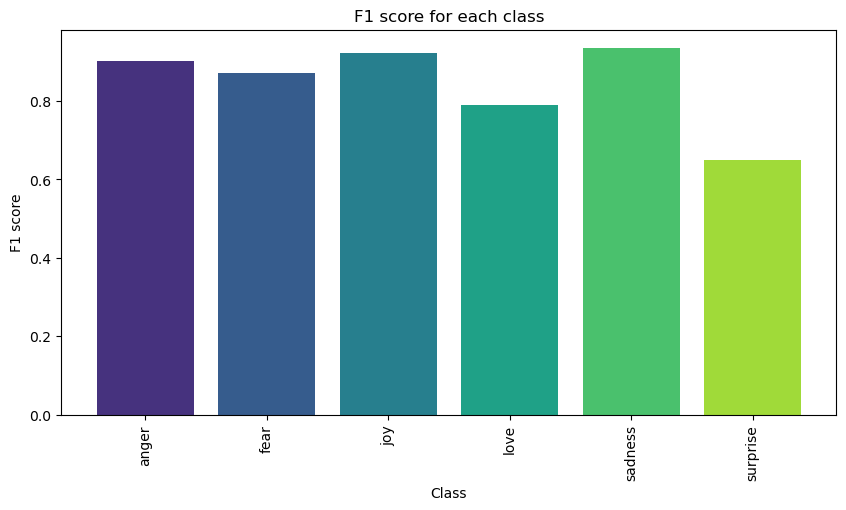

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.88                0.92                0.90                0.82                 275
fear                                0.88                0.86                0.87                0.77                 224
joy                                 0.91                0.94                0.92                0.86                 695
love                                0.80                0.77                0.79                0.65                 159
sadness                             0.94                0.93                0.94                0.88                 581
surprise                            0.77                0.56                0.65                0.48                  66
Macro avg                           0.86                0.83                0.84                0.74                2000
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


----------------------------------------------------------------------
Model: Bert
Dataset: TwitterData


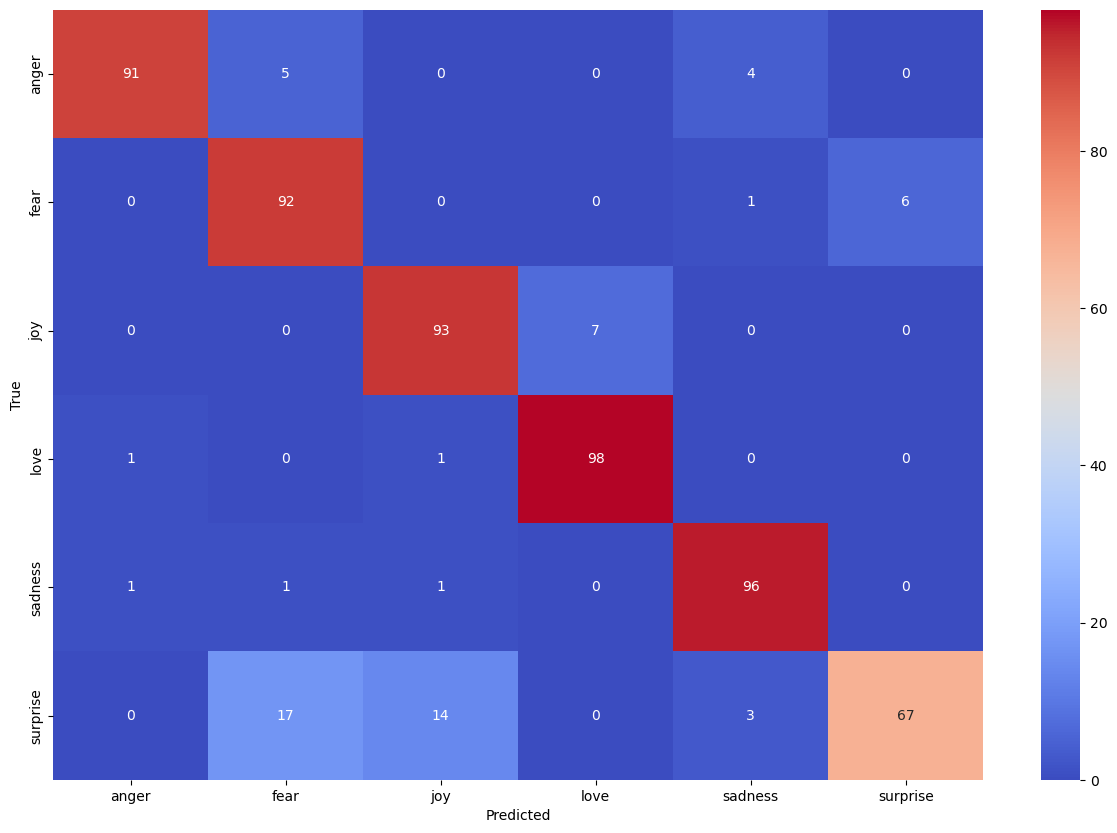

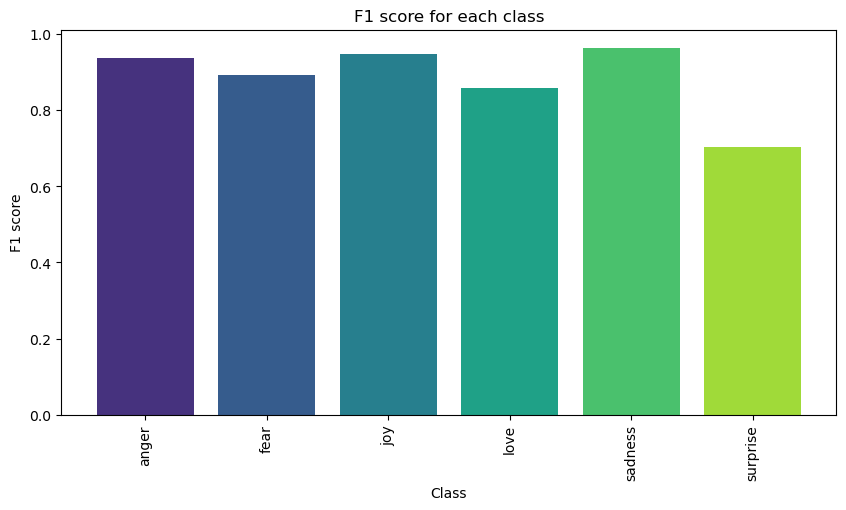

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.97                0.91                0.94                0.88                 275
fear                                0.87                0.92                0.89                0.81                 224
joy                                 0.97                0.93                0.95                0.90                 695
love                                0.76                0.98                0.86                0.75                 159
sadness                             0.97                0.96                0.96                0.93                 581
surprise                            0.75                0.67                0.70                0.54                  66
Macro avg                           0.88                0.89                0.88                0.80                2000
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: Roberta
Dataset: TwitterData


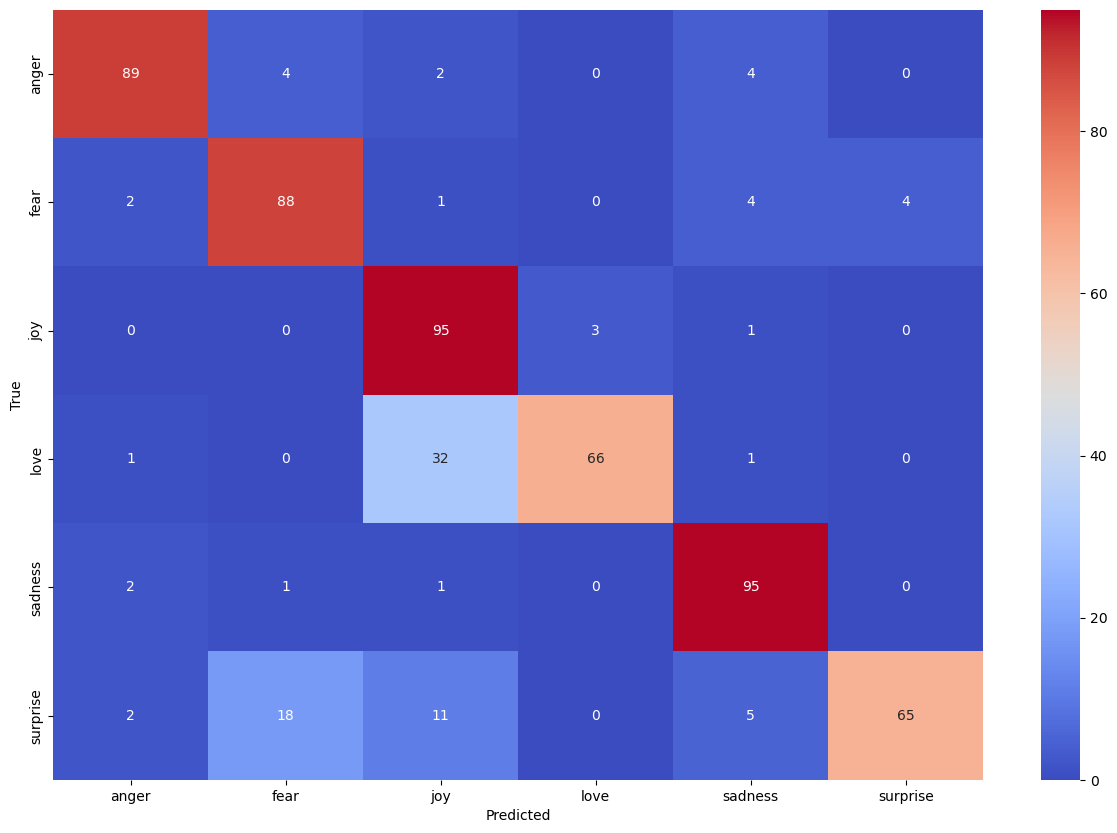

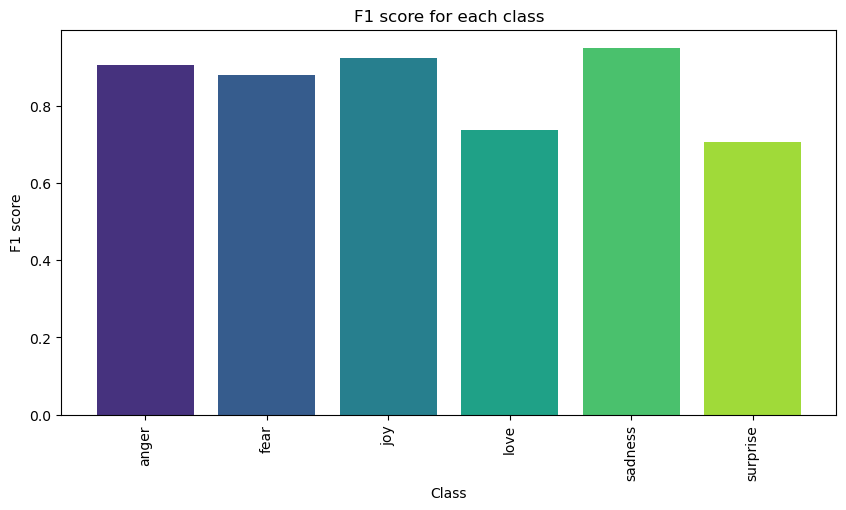

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.91                0.89                0.90                0.83                 275
fear                                0.88                0.88                0.88                0.79                 224
joy                                 0.90                0.95                0.92                0.86                 695
love                                0.83                0.66                0.74                0.58                 159
sadness                             0.95                0.95                0.95                0.90                 581
surprise                            0.77                0.65                0.70                0.54                  66
Macro avg                           0.87                0.83                0.85                0.75                2000
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: SocBert
Dataset: TwitterData


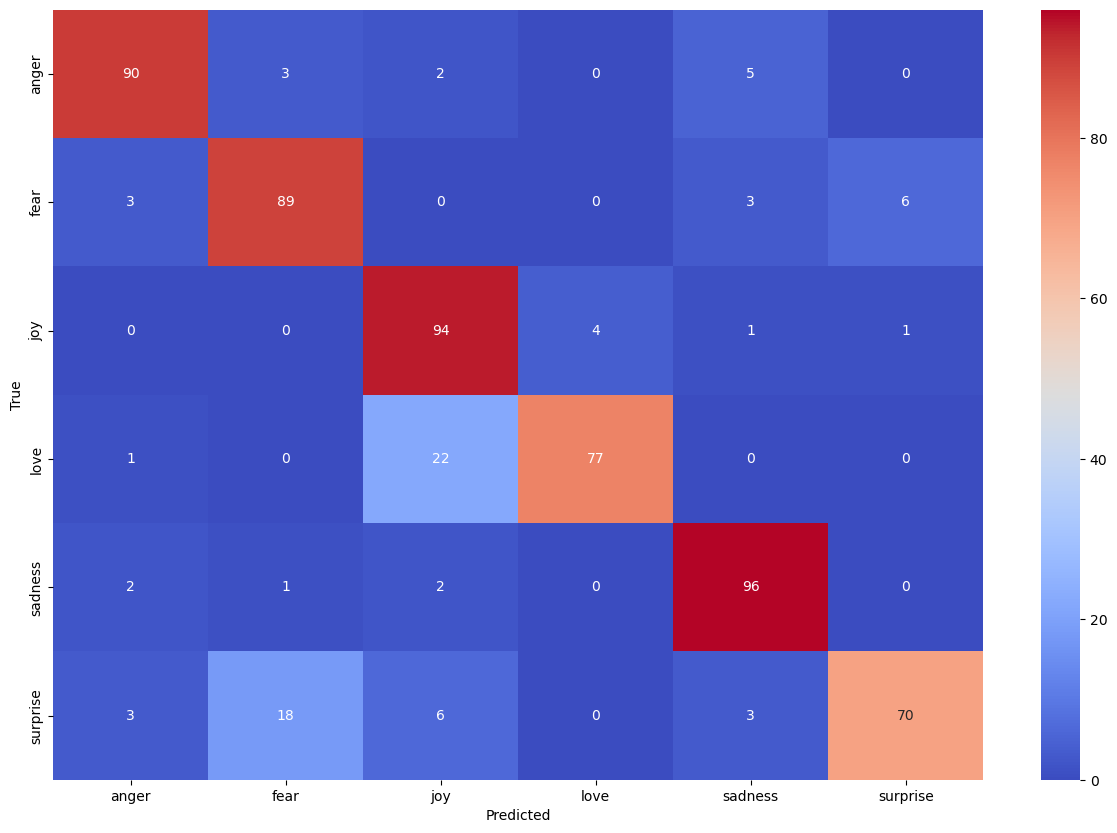

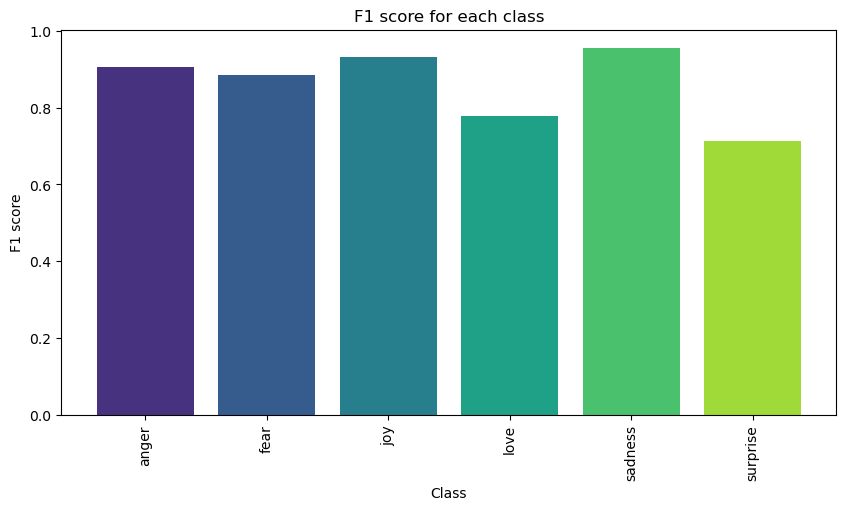

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.91                0.90                0.91                0.83                 275
fear                                0.88                0.89                0.88                0.79                 224
joy                                 0.92                0.94                0.93                0.87                 695
love                                0.79                0.77                0.78                0.64                 159
sadness                             0.96                0.96                0.96                0.91                 581
surprise                            0.73                0.70                0.71                0.55                  66
Macro avg                           0.87                0.86                0.86                0.77                2000
Micro avg

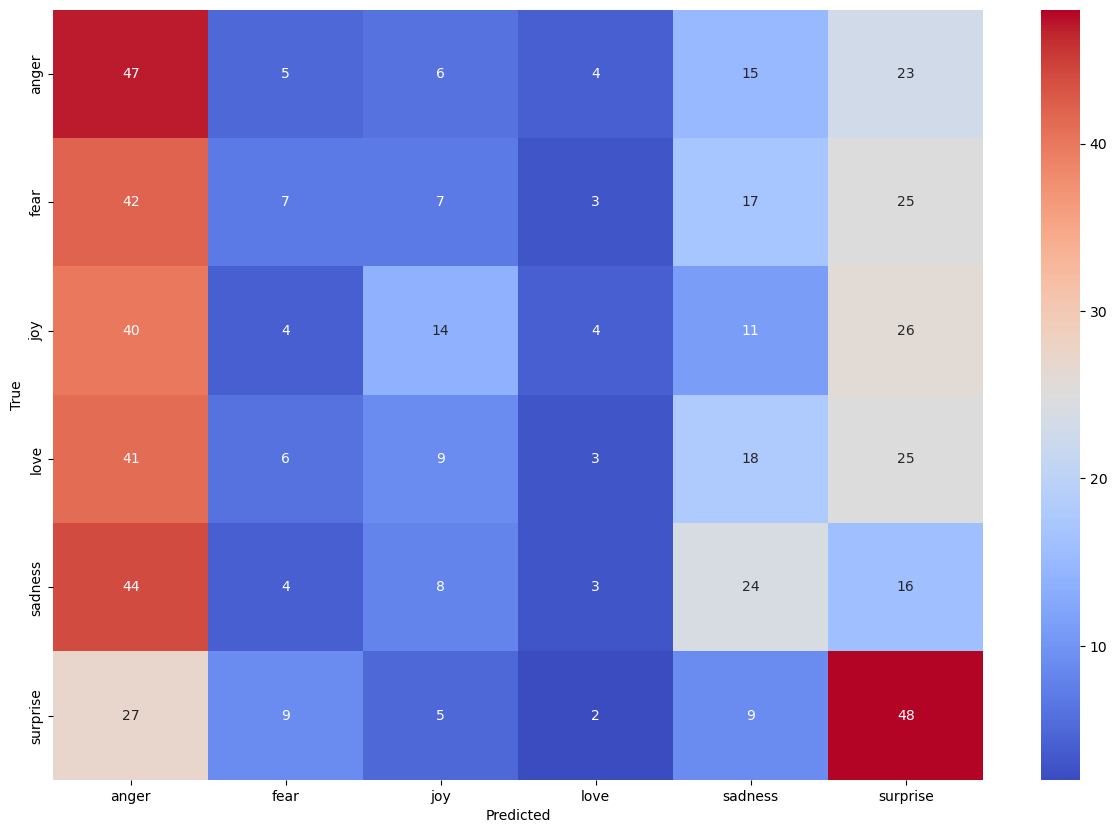

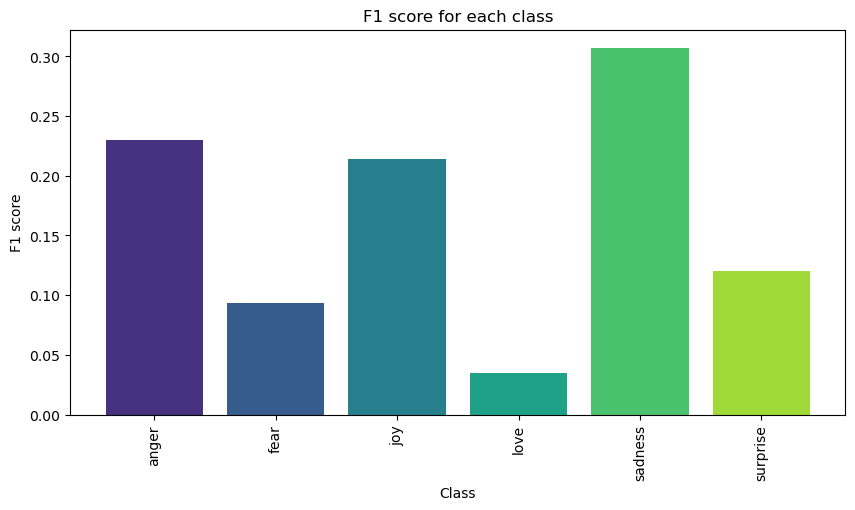

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.15                0.47                0.23                0.13                 275
fear                                0.15                0.07                0.09                0.05                 224
joy                                 0.49                0.14                0.21                0.12                 695
love                                0.06                0.03                0.03                0.02                 159
sadness                             0.42                0.24                0.31                0.18                 581
surprise                            0.07                0.48                0.12                0.06                  66
Macro avg                           0.22                0.24                0.17                0.09                2000
Micro avg

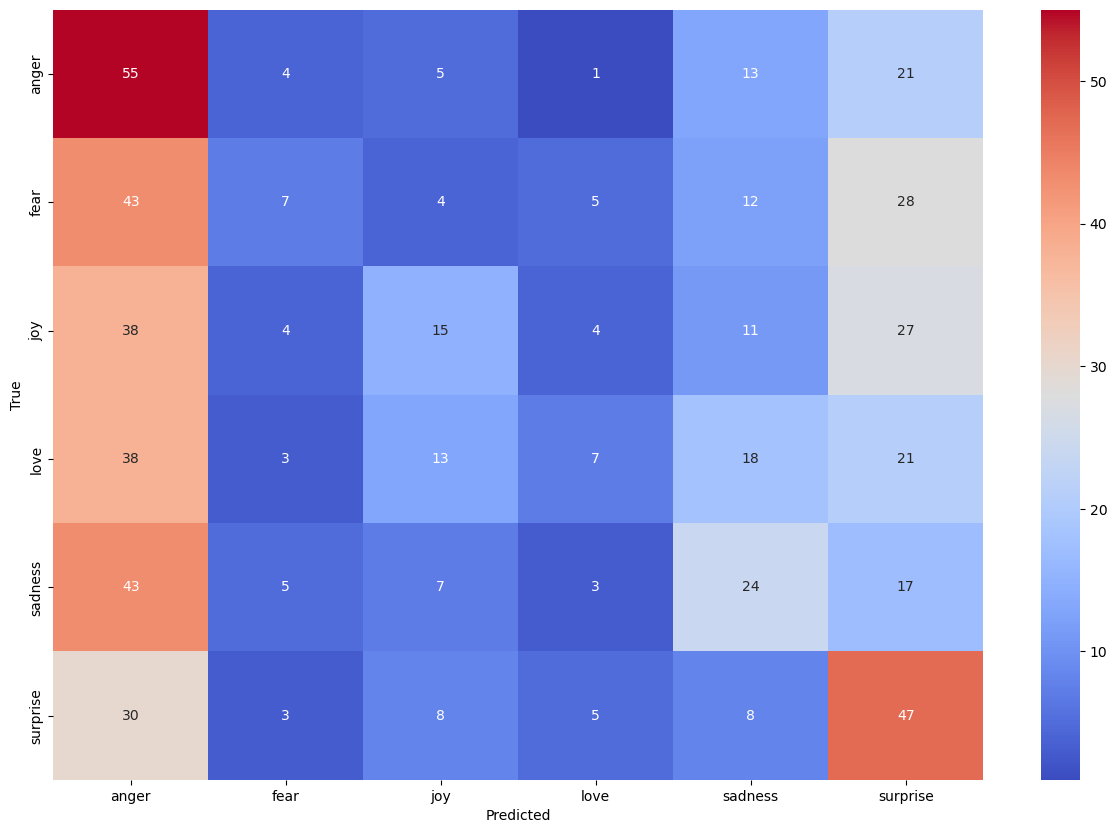

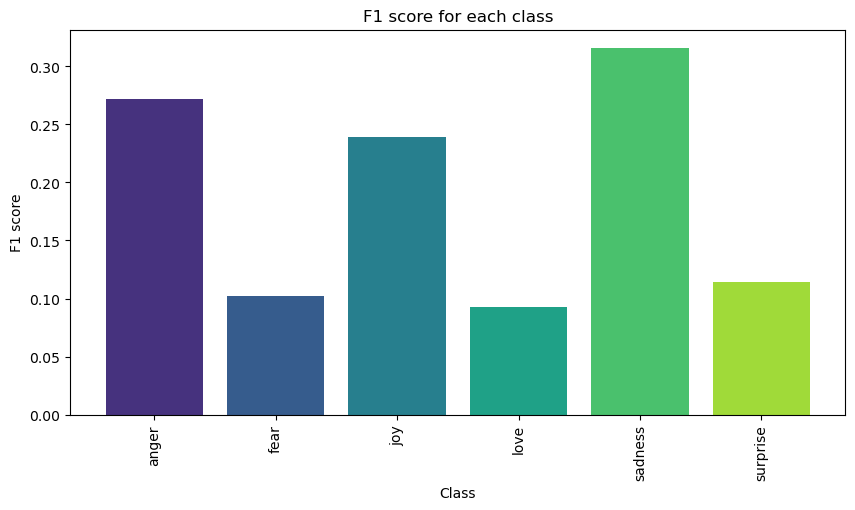

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.18                0.55                0.27                0.16                 275
fear                                0.18                0.07                0.10                0.05                 224
joy                                 0.55                0.15                0.24                0.14                 695
love                                0.14                0.07                0.09                0.05                 159
sadness                             0.45                0.24                0.32                0.19                 581
surprise                            0.06                0.47                0.11                0.06                  66
Macro avg                           0.26                0.26                0.19                0.11                2000
Micro avg

In [5]:
# print results for all models on all datasets
all_scores = {}
for dataset in DATASETS:
    all_scores[dataset] = print_dataset_results(dataset)

C:\Users\andre\AppData\Local\Temp\ipykernel_10204\1916895870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


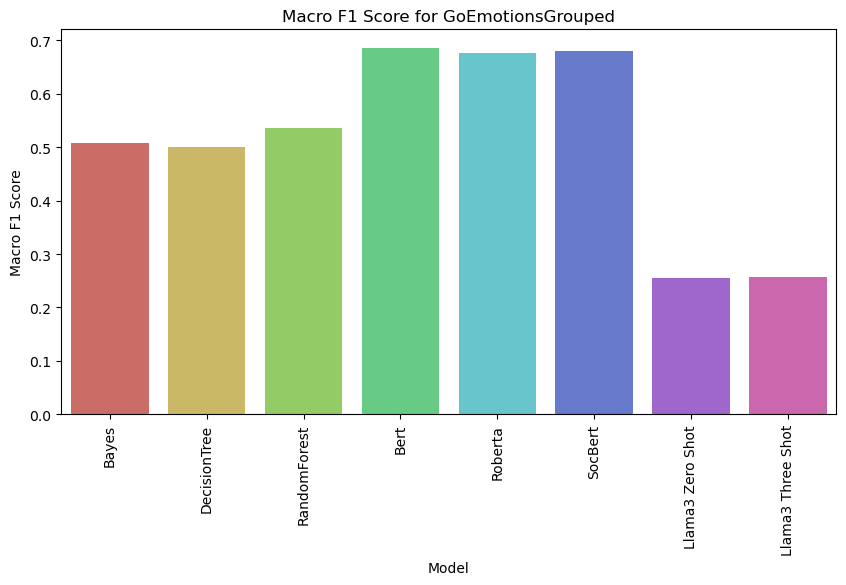

C:\Users\andre\AppData\Local\Temp\ipykernel_10204\1916895870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


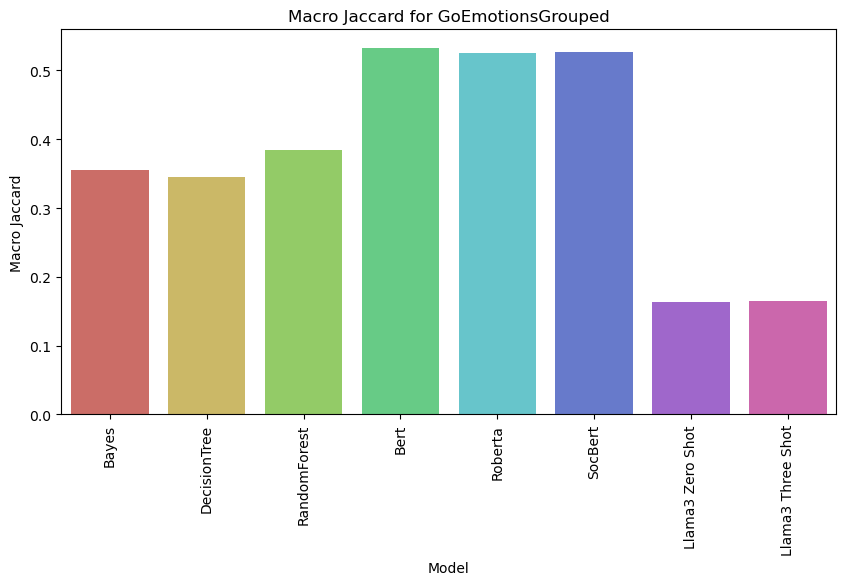

C:\Users\andre\AppData\Local\Temp\ipykernel_10204\1916895870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


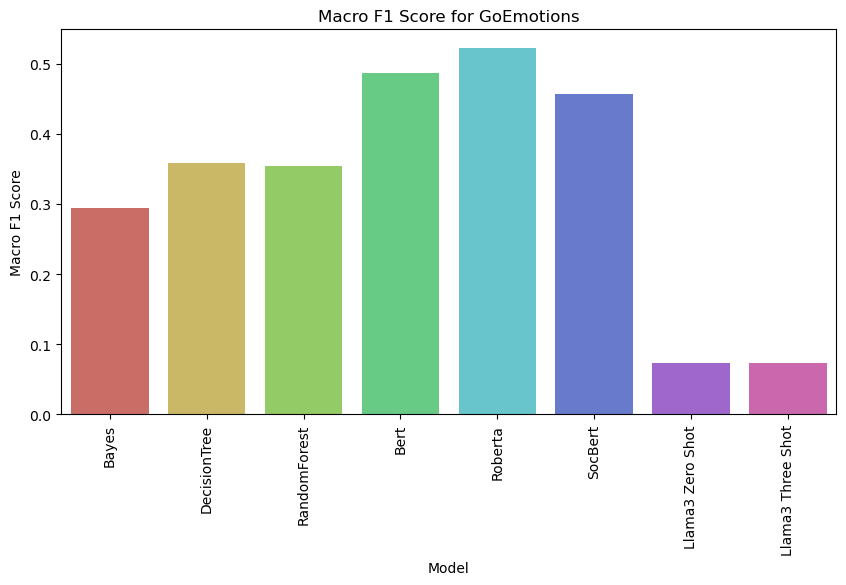

C:\Users\andre\AppData\Local\Temp\ipykernel_10204\1916895870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


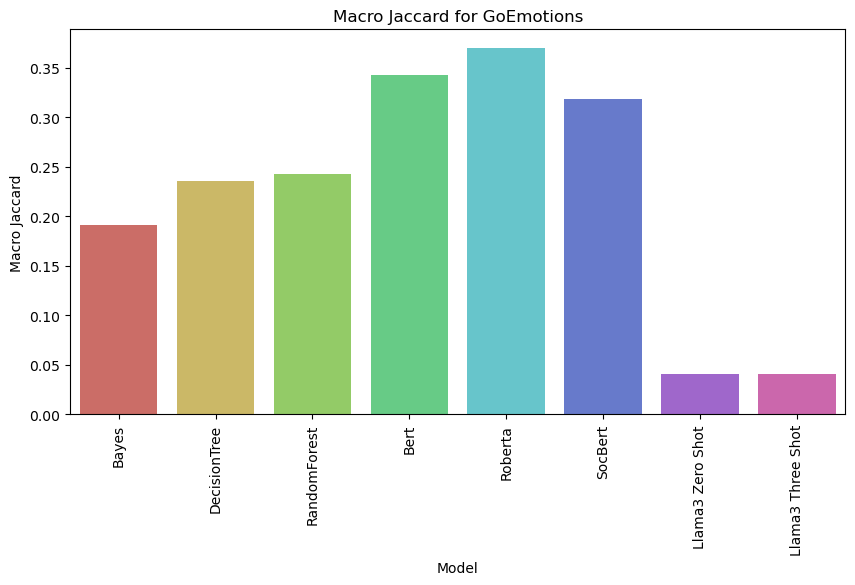

C:\Users\andre\AppData\Local\Temp\ipykernel_10204\1916895870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


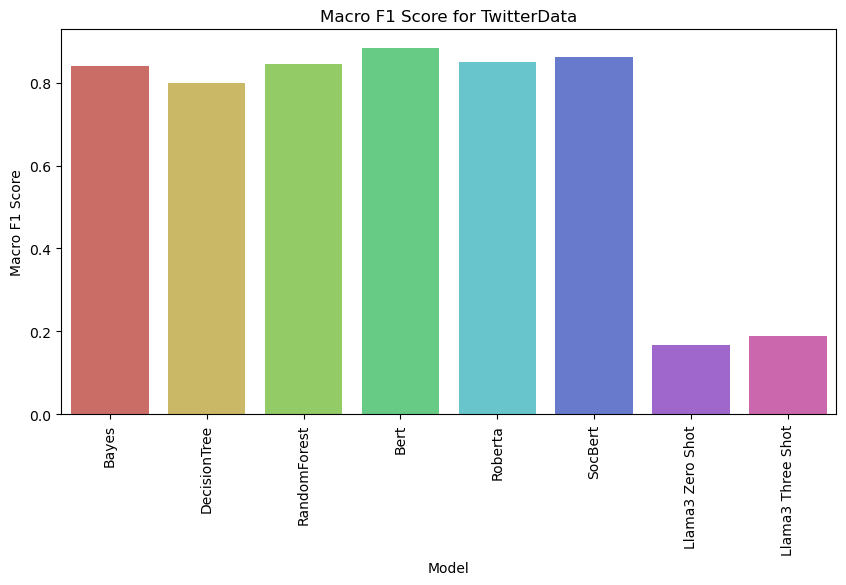

C:\Users\andre\AppData\Local\Temp\ipykernel_10204\1916895870.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


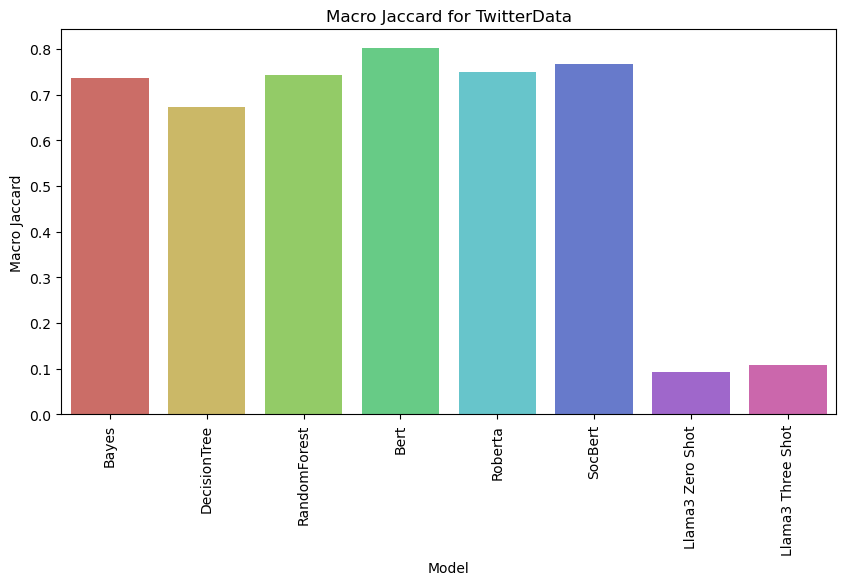

In [15]:
comparison_bar_plot(all_scores)

## Statistical testing

In [16]:
N_TESTS = 100
SAMPLE_SIZE = 200
# get best model for each dataset
best_models = {}
for dataset in DATASETS:
    best_model = max(all_scores[dataset].items(), key=lambda x: x[1]['macro avg']['f1-score'])[0]
    best_models[dataset] = best_model
    # get labels
    labels = get_dataset(dataset, cleaning=False)[2]
    labels = labels[labels.columns[1:]]
    # get best model predictions
    best_predictions = predict(best_model, dataset)
    # compare best model with all other models according to bootstrap test
    for model in MODELS:
        if model != best_model:
            # get predictions
            predictions = predict(model, dataset)
            if predictions is None:
                continue
            print(f"Bootstrap test between {best_model} and {model} on {dataset}")
            bootstrap_test(best_predictions.values, predictions.values, labels, n_tests=N_TESTS, sample_size=SAMPLE_SIZE, metric_fun=f1_score, metric_name="Macro F1", metric_params={"average": "macro", "zero_division": 0})
            print("----------------------------------------------------------------------")

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bootstrap test between Bert and Bayes on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.5069268892097168
Best model: first, with delta: 0.17930260025308442
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and DecisionTree on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.5006409541940328
Best model: first, with delta: 0.1855885352687685
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and RandomForest on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.5352818913338862
Best model: first, with delta: 0.15094759812891512
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Bert and Roberta on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.6763988525797205
Best model: first, with delta: 0.009830636883080723
Successes: 45/100
p-value: 0.45
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Bert and SocBert on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.680735772398856
Best model: first, with delta: 0.005493717063945303
Successes: 36/100
p-value: 0.36
----------------------------------------------------------------------
Bootstrap test between Bert and Llama3 Zero Shot on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.2548513818667227
Best model: first, with delta: 0.4313781075960786
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and Llama3 Three Shot on GoEmotionsGrouped
Initial Macro F1: 0.6862294894628013 0.2573573323741844
Best model: first, with delta: 0.42887215708861687
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Roberta and Bayes on GoEmotions
Initial Macro F1: 0.5226111666159293 0.29463289922272434
Best model: first, with delta: 0.22797826739320498
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and DecisionTree on GoEmotions
Initial Macro F1: 0.5226111666159293 0.3579163397609058
Best model: first, with delta: 0.1646948268550235
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and RandomForest on GoEmotions
Initial Macro F1: 0.5226111666159293 0.35377376998478965
Best model: first, with delta: 0.16883739663113967
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bootstrap test between Roberta and Bert on GoEmotions
Initial Macro F1: 0.5226111666159293 0.4864226108997564
Best model: first, with delta: 0.03618855571617291
Successes: 4/100
p-value: 0.04
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Roberta and SocBert on GoEmotions
Initial Macro F1: 0.5226111666159293 0.45720663811501483
Best model: first, with delta: 0.0654045285009145
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and Llama3 Zero Shot on GoEmotions
Initial Macro F1: 0.5226111666159293 0.07359380162183081
Best model: first, with delta: 0.4490173649940985
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and Llama3 Three Shot on GoEmotions
Initial Macro F1: 0.5226111666159293 0.0734787269326618
Best model: first, with delta: 0.44913243968326755
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bootstrap test between Bert and Bayes on TwitterData
Initial Macro F1: 0.8841444552354679 0.8392865812337855
Best model: first, with delta: 0.044857874001682396
Successes: 15/100
p-value: 0.15
----------------------------------------------------------------------
Bootstrap test between Bert and DecisionTree on TwitterData
Initial Macro F1: 0.8841444552354679 0.7982814688555931
Best model: first, with delta: 0.08586298637987477
Successes: 3/100
p-value: 0.03
----------------------------------------------------------------------
Bootstrap test between Bert and RandomForest on TwitterData
Initial Macro F1: 0.8841444552354679 0.8444647319584511
Best model: first, with delta: 0.039679723277016854
Successes: 9/100
p-value: 0.09
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Bert and Roberta on TwitterData
Initial Macro F1: 0.8841444552354679 0.8500326541039301
Best model: first, with delta: 0.03411180113153778
Successes: 14/100
p-value: 0.14
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at sarkerlab/SocBERT-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Bert and SocBert on TwitterData
Initial Macro F1: 0.8841444552354679 0.8612988270328255
Best model: first, with delta: 0.022845628202642465
Successes: 24/100
p-value: 0.24
----------------------------------------------------------------------
Bootstrap test between Bert and Llama3 Zero Shot on TwitterData
Initial Macro F1: 0.8841444552354679 0.16643387964049805
Best model: first, with delta: 0.7177105755949699
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and Llama3 Three Shot on TwitterData
Initial Macro F1: 0.8841444552354679 0.1892005697860076
Best model: first, with delta: 0.6949438854494603
Successes: 0/100
p-value: 0.0
----------------------------------------------------------------------
